In [1]:
import pandas as pd
import numpy as np
from tkinter import Tk
import os
import datetime
import xlsxwriter

Zuurstofmeting analyse Weesp

In [3]:
o2_loc = r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Zuurstofmeting\aanvulling zuurstofmeting.xlsx"
df_o2 = pd.read_excel(o2_loc)
df_o2.set_index('sTime', drop=True, inplace=True)

In [137]:
print(df_o2['7009 AT_QT113_AM'][70:130].max(), df_o2['7009 AT_QT113_AM'][70:130].min())
print(df_o2['7009 AT_QT113_AM'][70:130].idxmax(), df_o2['7009 AT_QT113_AM'][70:130].idxmin())
print((0.0-2.35)/(29*60), "mg/(l*s)")

2.35 0.0
2020-12-01 01:39:11 2020-12-01 02:08:12
-0.0013505747126436782 mg/(l*s)


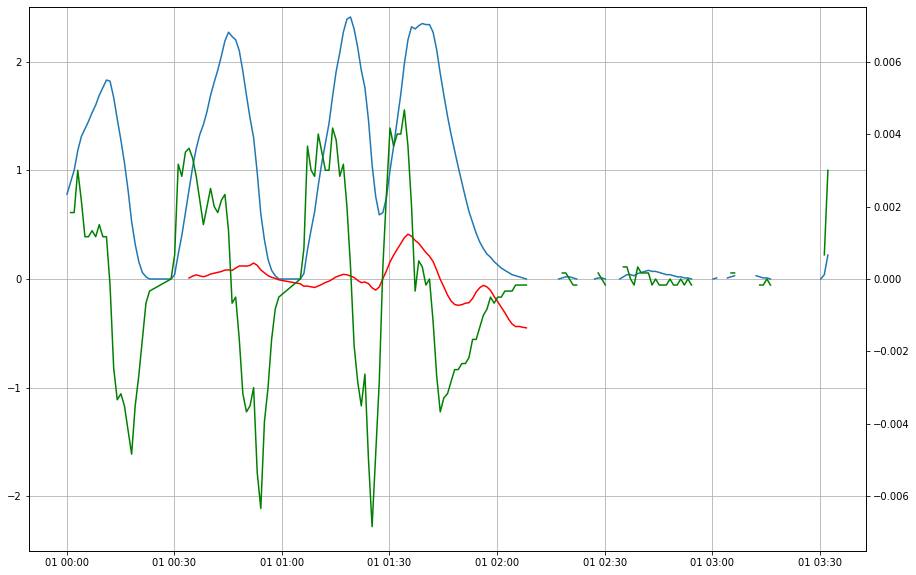

In [177]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(df_o2.index[0:200], df_o2['7009 AT_QT113_AM'][0:200])
ax.set_ylim(-2.5,2.5)
plt.grid(True)
ax2 = ax.twinx()
ax2.plot(df_o2.index[0:200], df_o2["Moving_Average_AT1"][0:200], color="red")
ax2.plot(df_o2.index[0:200], df_o2["Afgeleide_AT1"][0:200], color="green")
ax2.set_ylim(-0.0075,0.0075)
plt.show()

In [15]:
df_o2["Afgeleide_AT1"] = df_o2["7009 AT_QT113_AM"].diff() / df_o2["7009 AT_QT113_AM"].index.to_series().diff().dt.total_seconds()

In [138]:
df_o2['Moving_Average_AT1'] = df_o2["Afgeleide_AT1"].rolling(window=29).mean()

In [306]:
df.loc["2020-12-13 22:45":"2020-12-13 23:02", "7009 AT_QT112_AM"].mean()

2.6737222222222226

In [307]:
df.loc["2020-12-13 19:54":"2020-12-13 20:05", "7010 AT_QT112_AM"].mean()

2.9753333333333334

Slibbezinking

In [2]:
opp = 1401

In [3]:
def read_excelfiles(extension):
    # Ask for directory
    # from tkinter.filedialog import askdirectory
    # path_files = askdirectory(title='Selecteer de map met alle ruwe input') # shows dialog box and return the path
    file_path = r"C:\Users\hnx\Desktop\Weesp\Vervolg"
    list_files = []

    for filename in os.listdir(file_path):
        if filename.endswith(extension):
            list_files.append(os.path.join(file_path, filename))
        else:
            continue

    return list_files

In [4]:
# Converteer excel naar csv, dat leest veel sneller in.
convert = True

if convert:
    list_files_xlsx = read_excelfiles(extension='xlsx')
    for el in list_files_xlsx:
        print(el)
        pre, ext = os.path.splitext(el)
        new_name = pre + ".csv"
        
        if not os.path.exists(new_name):
            df_i = pd.read_excel(el)
            print(new_name)
            df_i.to_csv(new_name, index=False)

C:\Users\hnx\Desktop\Weesp\Vervolg\Week 24.xlsx
C:\Users\hnx\Desktop\Weesp\Vervolg\Week 25.xlsx
C:\Users\hnx\Desktop\Weesp\Vervolg\Week 25.csv
C:\Users\hnx\Desktop\Weesp\Vervolg\Weken_oud.xlsx
C:\Users\hnx\Desktop\Weesp\Vervolg\Weken_oud.csv
C:\Users\hnx\Desktop\Weesp\Vervolg\Weken_oud2.xlsx
C:\Users\hnx\Desktop\Weesp\Vervolg\Weken_oud2.csv


Lees data en maak onderscheid twee methodes


In [5]:
list_files = read_excelfiles(extension='csv')

In [6]:
# read csv files
dfs = [pd.read_csv(el, sep=',',index_col=[0], parse_dates=[0], decimal='.') for el in list_files]

df = pd.concat(dfs).sort_index()
df = df.max(level=0)

# Calculate flows

df["Influentdebiet1"] = df["7003 RGI_FTxyz_PW"]*np.where(df["7006 VW_A150_O"].isna(),1,df["7006 VW_A150_O"])/np.where(df["7006 VW_A150_O"]+df["7006 VW_A250_O"]>0,df["7006 VW_A150_O"]+df["7006 VW_A250_O"],2)
df["Influentdebiet2"] = df["7003 RGI_FTxyz_PW"]*np.where(df["7006 VW_A250_O"].isna(),1,df["7006 VW_A250_O"])/np.where(df["7006 VW_A150_O"]+df["7006 VW_A250_O"]>0,df["7006 VW_A150_O"]+df["7006 VW_A250_O"],2)
df["Opstroomsnelheid1"] = df["Influentdebiet1"]/opp
df["Opstroomsnelheid2"] = df["Influentdebiet2"]/opp

# Onderscheid data in 2 methodes: compleet gebruik luchtkleppen 7019 BC_A130_D, incompleet gebruik waterhoogte 7009 AT_LT114_AM
df_compleet = df[df["7019 BC_A130_D"].notnull()]
df_incompleet1 = df[(df["7019 BC_A130_D"].isnull()) & (df["7009 AT_LT114_AM"].notnull())]
df_incompleet2 = df[(df["7019 BC_A151_D"].isnull()) & (df["7010 AT_LT114_AM"].notnull())]


In [7]:
df_incompleet1 = df_incompleet1[(df_incompleet1.index<"2021-04-02 13:02:00")|(df_incompleet1.index>"2021-04-02 13:04:00")]
df_compleet.loc["2020-09-02 11:04:00":"2020-09-02 11:05:00", "7009 AT_LT114_AM"] = 4.64

C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
df_compleet["7009 AT_LT114_AM"].mean()

4.659971196137438

Methode 1: met waterhoogte

In [9]:
# Vindt alle cyclussen: hun totale duur en begin- en eindtijd.
# AT 1

m_i = 0
begin_cyclus1 = []

# Incompleet
while m_i < len(df_incompleet1.index):
    m = df_incompleet1.index[m_i]

    i_m108 = m - datetime.timedelta(minutes=108)
    i_p108 = m + datetime.timedelta(minutes=108)

    if (df_incompleet1.loc[m, "7009 AT_LT114_AM"] == df_incompleet1.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min()):
        i_m1 = m - datetime.timedelta(minutes=1)
        i_p1 = m + datetime.timedelta(minutes=1)
        
        if (df_incompleet1.loc[m, "7009 AT_LT114_AM"] <= df_incompleet1.loc[i_m1, "7009 AT_LT114_AM"]) and\
            (df_incompleet1.loc[m, "7009 AT_LT114_AM"] <= df_incompleet1.loc[i_p1, "7009 AT_LT114_AM"]):
            begin_cyclus1.append([m,1,np.nan,np.nan,np.nan,np.nan,np.nan])
            m_i += 50
        
        else:
            m_i += 1
       
    else:
        m_i += 1

In [10]:
# Vindt alle cyclussen: hun totale duur en begin- en eindtijd.
# AT2
m_i = 0
begin_cyclus2 = []

# Incompleet
while m_i < len(df_incompleet2.index):
    m = df_incompleet2.index[m_i]    

    i_m108 = m - datetime.timedelta(minutes=108)
    i_p108 = m + datetime.timedelta(minutes=108)

    try:
        if df_incompleet2.loc[m, "7010 AT_LT114_AM"] == df_incompleet2.loc[i_m108:i_p108, "7010 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_incompleet2.loc[m, "7010 AT_LT114_AM"] <= df_incompleet2.loc[i_m1, "7010 AT_LT114_AM"]) and\
                (df_incompleet2.loc[m, "7010 AT_LT114_AM"] <= df_incompleet2.loc[i_p1, "7010 AT_LT114_AM"]):
                begin_cyclus2.append([m,1,np.nan,np.nan,np.nan,np.nan,np.nan])
                m_i += 50
            
            else:
                m_i += 1

        else:
            m_i += 1

    except:

        m_i += 1

In [11]:
# Bepaal gemiddelde opstroomsnelheid, begin bezinktijd en bezinkduur, slibgehalte, waterhoogte
# AT 1
results_1a = []

for a in range(len(begin_cyclus1)-1):
    duur = begin_cyclus1[a+1][0] - begin_cyclus1[a][0]
    begin_cyclus1[a][2] = duur
   
    if datetime.timedelta(minutes=270) < duur < datetime.timedelta(minutes=292):
        start_date = begin_cyclus1[a][0] + datetime.timedelta(minutes=168)

    elif datetime.timedelta(minutes=200) < duur < datetime.timedelta(minutes=230):
        start_date = begin_cyclus1[a][0] + datetime.timedelta(minutes=126)

    else:
        continue

    end = False

    j = start_date
    max_date = j+datetime.timedelta(minutes=170)

    while not end:
        j = j + datetime.timedelta(minutes=1)
        try:
            if j > max_date:
                end = True

            elif df_incompleet1.loc[j, "7009 AT_QT112_AM"] < 1.0:
                end_date = j
                # j_p10 = j+datetime.timedelta(minutes=20)
                # selection = df_incompleet1.loc[j:j_p10, "7009 AT_QT112_AM"]
                # minimum = selection.min()

                # if minimum < 0.1:
                #     small_selection = selection.where(selection<0.1)
                #     end_date = small_selection.first_valid_index()
                # else:
                #     end_date = df_incompleet1.loc[j:j_p10, "7009 AT_QT112_AM"].idxmin()

                end = True

        except:
            continue
    
    try:
        average = np.mean(df_incompleet1.loc[start_date:end_date, "Opstroomsnelheid1"])
        duration = end_date-start_date
        hours = duration.total_seconds()/3600
        results_1a.append([start_date, begin_cyclus1[a][0], duur, df_incompleet1.loc[start_date, "7009 AT_QT112_AM"],\
            df_incompleet1.loc[start_date, "7009 AT_LT114_AM"], average, hours])
    except:
        continue

df_temp1 = pd.DataFrame(results_1a, columns=["sTime", "Begin_cyclus1", "Cyclusduur1", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
df_temp1 = df_temp1[df_temp1["Duur1"]>0]
df_temp1 = df_temp1.set_index(keys="sTime", drop=True)


In [12]:
# Bepaal gemiddelde opstroomsnelheid, begin bezinktijd en bezinkduur, slibgehalte, waterhoogte
# AT 2
results_2a = []
for a in range(len(begin_cyclus2)-1):
    duur = begin_cyclus2[a+1][0] - begin_cyclus2[a][0]
    begin_cyclus2[a][2] = duur
   
    if datetime.timedelta(minutes=270) < duur < datetime.timedelta(minutes=292):
        start_date = begin_cyclus2[a][0] + datetime.timedelta(minutes=168)

    elif datetime.timedelta(minutes=200) < duur < datetime.timedelta(minutes=230):
        start_date = begin_cyclus2[a][0] + datetime.timedelta(minutes=126)
    else:
        continue

    end = False

    j = start_date
    max_date = j+datetime.timedelta(minutes=170)

    while not end:
        j = j + datetime.timedelta(minutes=1)
        try:
            if j > max_date:
                end = True

            elif df_incompleet2.loc[j, "7010 AT_QT112_AM"] < 1.0:
                end_date = j
                # j_p10 = j+datetime.timedelta(minutes=20)
                # selection = df_incompleet2.loc[j:j_p10, "7010 AT_QT112_AM"]
                # minimum = selection.min()

                # if minimum < 0.1:
                #     small_selection = selection.where(selection<0.1)
                #     end_date = small_selection.first_valid_index()
                # else:
                #     end_date = df_incompleet2.loc[j:j_p10, "7010 AT_QT112_AM"].idxmin()

                end = True

        except:
            continue
    
    try:
        average = np.mean(df_incompleet2.loc[start_date:end_date, "Opstroomsnelheid2"])
        duration = end_date-start_date
        hours = duration.total_seconds()/3600
        results_2a.append([start_date, begin_cyclus2[a][0], duur, df_incompleet2.loc[start_date, "7010 AT_QT112_AM"],\
            df_incompleet2.loc[start_date, "7010 AT_LT114_AM"], average, hours])
    except:
        continue

df_temp2 = pd.DataFrame(results_2a, columns=["sTime", "Begin_cyclus2", "Cyclusduur2", "Slibgehalte2", "Waterhoogte2", "Opstroomsnelheid2", "Duur2"])
df_temp2 = df_temp2[df_temp2["Duur2"]>0]
df_temp2 = df_temp2.set_index(keys="sTime", drop=True)

Methode 2: met luchtkleppen

In [13]:
# Loop and find cycles and average upwards flow in cycle part 2
# AT 1

m_i = 0
begin_cyclus1a = []

# Incompleet
while m_i < len(df_compleet.index):
    m = df_compleet.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df_compleet.loc[m, "7009 AT_LT114_AM"] == df_compleet.loc[i_m108:i_p108, "7009 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_compleet.loc[m, "7009 AT_LT114_AM"] <= df_compleet.loc[i_m1, "7009 AT_LT114_AM"]) and\
                (df_compleet.loc[m, "7009 AT_LT114_AM"] <= df_compleet.loc[i_p1, "7009 AT_LT114_AM"]):
                begin_cyclus1a.append([m])
                m_i += 50
            
            else:
                m_i += 1
        
        else:
            m_i += 1
    except:
        m_i += 1

# Loop and find cycles and average upwards flow in cycle part 2
# AT 2

m_i = 0
begin_cyclus2a = []

# Incompleet
while m_i < len(df_compleet.index):
    m = df_compleet.index[m_i]
    try:
        i_m108 = m - datetime.timedelta(minutes=108)
        i_p108 = m + datetime.timedelta(minutes=108)

        if df_compleet.loc[m, "7010 AT_LT114_AM"] == df_compleet.loc[i_m108:i_p108, "7010 AT_LT114_AM"].min():
            i_m1 = m - datetime.timedelta(minutes=1)
            i_p1 = m + datetime.timedelta(minutes=1)
            
            if (df_compleet.loc[m, "7010 AT_LT114_AM"] <= df_compleet.loc[i_m1, "7010 AT_LT114_AM"]) and\
                (df_compleet.loc[m, "7010 AT_LT114_AM"] <= df_compleet.loc[i_p1, "7010 AT_LT114_AM"]):
                begin_cyclus2a.append([m])
                m_i += 50
            
            else:
                m_i += 50
        
        else:
            m_i += 1
       
    except:
        m_i += 1

In [61]:
begin_cyclus1a

[[Timestamp('2021-05-31 01:14:00'), Timedelta('0 days 04:49:00')],
 [Timestamp('2021-05-31 06:03:00'), Timedelta('0 days 04:48:00')],
 [Timestamp('2021-05-31 10:51:00'), Timedelta('0 days 04:49:00')],
 [Timestamp('2021-05-31 15:40:00'), Timedelta('0 days 04:47:00')],
 [Timestamp('2021-05-31 20:27:00'), Timedelta('0 days 04:49:00')],
 [Timestamp('2021-06-01 01:16:00'), Timedelta('0 days 04:47:00')],
 [Timestamp('2021-06-01 06:03:00'), Timedelta('0 days 04:47:00')],
 [Timestamp('2021-06-01 10:50:00'), Timedelta('0 days 04:50:00')],
 [Timestamp('2021-06-01 15:40:00'), Timedelta('0 days 04:47:00')],
 [Timestamp('2021-06-01 20:27:00'), Timedelta('0 days 04:49:00')],
 [Timestamp('2021-06-02 01:16:00'), Timedelta('0 days 04:46:00')],
 [Timestamp('2021-06-02 06:02:00'), Timedelta('0 days 04:48:00')],
 [Timestamp('2021-06-02 10:50:00'), Timedelta('0 days 04:49:00')],
 [Timestamp('2021-06-02 15:39:00'), Timedelta('0 days 04:47:00')],
 [Timestamp('2021-06-02 20:26:00'), Timedelta('0 days 04:51:00

In [14]:
# Vindt cyclusduur
for a in range(len(begin_cyclus1a)-1):
    duur = begin_cyclus1a[a+1][0] - begin_cyclus1a[a][0]
    begin_cyclus1a[a].append(duur)

for a in range(len(begin_cyclus2a)-1):
    duur = begin_cyclus2a[a+1][0] - begin_cyclus2a[a][0]
    begin_cyclus2a[a].append(duur)
   

In [15]:
# Maak dataframes van cyclusdata compleet
df_temp1a = pd.DataFrame(begin_cyclus1a, columns=["Begin_cyclus1", "Cyclusduur1"])
df_temp1a = df_temp1a.set_index(keys="Begin_cyclus1", drop=True)

df_temp2a = pd.DataFrame(begin_cyclus2a, columns=["Begin_cyclus2", "Cyclusduur2"])
df_temp2a = df_temp2a.set_index(keys="Begin_cyclus2", drop=True)

In [16]:
df_temp1a.head()

Cyclusduur1
Begin_cyclus1                      
2021-05-31 01:14:00 0 days 04:49:00
2021-05-31 06:03:00 0 days 04:48:00
2021-05-31 10:51:00 0 days 04:49:00
2021-05-31 15:40:00 0 days 04:47:00
2021-05-31 20:27:00 0 days 04:49:00

In [17]:
results_at1 = []
results_at2 = []

for i in df_compleet.index[1:]:
    i_1 = i - datetime.timedelta(minutes=1)
    try:
        if df_compleet.loc[i, "7019 BC_A130_D"] > 0 and df_compleet.loc[i_1, "7019 BC_A130_D"] == 0:
            start_date = i_1
            end = False
            j = i
            while not end:
                j += datetime.timedelta(minutes=1)

                try:
                    if j >= df_compleet.index[-1]:
                        print("True")
                        end =True

                    if (df_compleet.loc[j, "7009 AT_QT112_AM"] < 1.0) and (df_compleet.loc[j+datetime.timedelta(minutes=1), "7009 AT_QT112_AM"] < 1.0):
                        end_date = j
                        end = True
                except:
                    continue

            average = np.mean(df_compleet.loc[start_date:end_date, "Opstroomsnelheid1"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600

            results_at1.append([start_date, df_compleet.loc[start_date, "7009 AT_QT112_AM"],\
                    df_compleet.loc[start_date,"7009 AT_LT114_AM"], average, hours])     

        # AT 2

        if df_compleet.loc[i, "7019 BC_A151_D"] > 0 and df_compleet.loc[i_1, "7019 BC_A151_D"] == 0:
            start_date = i_1

            end = False
            j = i
            while not end:
                j += datetime.timedelta(minutes=1)
                try:
                    if j >= df_compleet.index[-1]:
                        print("True")
                        end =True

                    if (df_compleet.loc[j, "7010 AT_QT112_AM"] < 1.0) and (df_compleet.loc[j+datetime.timedelta(minutes=1), "7010 AT_QT112_AM"] < 1.0):
                        end_date = j
                        end = True

                except:
                    continue

            average = np.mean(df_compleet.loc[start_date:end_date, "Opstroomsnelheid2"])
            duration = end_date-start_date
            hours = duration.total_seconds()/3600

            results_at2.append([start_date, df_compleet.loc[start_date, "7010 AT_QT112_AM"],\
                    df_compleet.loc[start_date,"7010 AT_LT114_AM"], average, hours])
    except:
        continue

    if i==df_compleet.index[-1]:
        break


In [18]:
df1 = pd.DataFrame(results_at1, columns=["sTime", "Slibgehalte1", "Waterhoogte1", "Opstroomsnelheid1", "Duur1"])
df2 = pd.DataFrame(results_at2, columns=["sTime", "Slibgehalte2", "Waterhoogte2", "Opstroomsnelheid2", "Duur2"])
df1.set_index(keys="sTime", drop=True, inplace = True)
df2.set_index(keys="sTime", drop=True, inplace = True)

In [19]:
# Vind juiste cyclusduur bij df1 en df2 uit df_temp1a en df_temp2a
# AT1
dict_cyclus1 = {}
for el in df1.index:
    try:
        num = df_temp1a.index.get_loc(el, method='ffill')
        diff = el - df_temp1a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            dict_cyclus1[el] = (df_temp1a.index[num], df_temp1a.iloc[num]["Cyclusduur1"])
    except:
        print("No previous value")

df1_dict = pd.DataFrame.from_dict(dict_cyclus1, columns=['Begin_cyclus1', 'Cyclusduur1'], orient='index')
df1 = pd.merge(df1, df1_dict, left_index=True, right_index=True, how='left')
print(df1.head())

# AT2
dict_cyclus2 = {}
for el in df2.index:
    try:
        num = df_temp2a.index.get_loc(el, method='ffill')
        diff = el - df_temp2a.index[num]
        compare = pd.Timedelta('0 days 03:20:00')
        if diff < compare:
            dict_cyclus2[el] = (df_temp2a.index[num], df_temp2a.iloc[num]["Cyclusduur2"])
    except:
        print("No previous value")

df2_dict = pd.DataFrame.from_dict(dict_cyclus2, columns=['Begin_cyclus2', 'Cyclusduur2'], orient='index')
df2 = pd.merge(df2, df2_dict, left_index=True, right_index=True, how='left')

                     Slibgehalte1  Waterhoogte1  Opstroomsnelheid1     Duur1  \
sTime                                                                          
2021-05-31 04:04:00         2.825         4.528           0.015708  0.283333   
2021-05-31 08:52:00         2.827         4.591           0.146642  0.283333   
2021-05-31 13:40:00         2.777         4.689           0.072833  0.300000   
2021-05-31 18:28:00         2.743         4.577           0.131426  0.300000   
2021-05-31 23:16:00         2.778         4.650           0.132289  0.300000   

                          Begin_cyclus1     Cyclusduur1  
sTime                                                    
2021-05-31 04:04:00 2021-05-31 01:14:00 0 days 04:49:00  
2021-05-31 08:52:00 2021-05-31 06:03:00 0 days 04:48:00  
2021-05-31 13:40:00 2021-05-31 10:51:00 0 days 04:49:00  
2021-05-31 18:28:00 2021-05-31 15:40:00 0 days 04:47:00  
2021-05-31 23:16:00 2021-05-31 20:27:00 0 days 04:49:00  
No previous value


In [20]:
df1 = df1.drop_duplicates()
df2 = df2.drop_duplicates()

In [21]:
df1_tot = df_temp1.append(df1)
df2_tot = df_temp2.append(df2)

In [22]:
# df1_tot.loc["2020-08-01"]

In [23]:
# Maandag 14 december is de sensor met een duidelijke blauwe schakel op 3.86 m gehangen. 
# Keuze 1 is voor 14 december 2020 3.25 [m], daarna 3.86
# Keuze 2 is altijd 3.25 [m]
# Keuze 3 is altijd
keuze_sensor = 1
if keuze_sensor == 1:
    df1_tot["Level sensor1"] = np.where(df1_tot.index<datetime.datetime(2020, 12, 1, 14),3.25,3.86)
    df2_tot["Level sensor2"] = np.where(df2_tot.index<datetime.datetime(2020, 12, 1, 14),3.25,3.86)
elif keuze_sensor == 2:
    df1_tot["Level sensor1"] = 3.25
    df2_tot["Level sensor2"] = 3.25
elif keuze_sensor == 3:
    df1_tot["Level sensor1"] = 3.86
    df2_tot["Level sensor2"] = 3.86

<AxesSubplot:xlabel='sTime'>

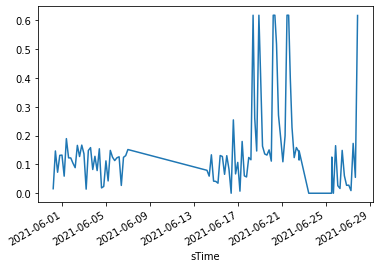

In [24]:
df1_tot["Opstroomsnelheid1"].plot()


In [25]:
df1_tot["delta_h1"] = df1_tot["Waterhoogte1"] - df1_tot["Level sensor1"]
df2_tot["delta_h2"] = df2_tot["Waterhoogte2"] - df2_tot["Level sensor2"]

SVI inlezen en toevoegen

In [26]:
svi_loc = r"C:\Users\hnx\Desktop\Weesp\Vervolg\SVI\SVI_bar.xlsx"
df_SVI = pd.read_excel(svi_loc)
df_SVI.set_index('sTime', drop=True, inplace=True)

df_SVI1 = df_SVI["SVI1"]
df_SVI2 = df_SVI["SVI2"]

df_SVI1 = df_SVI1.dropna()
df_SVI2 = df_SVI2.dropna()

# df_SVI1 = df_SVI1.str.strip().astype(bool)
# df_SVI2 = df_SVI2.str.strip().astype(bool)

svi1_dict = {}
svi2_dict = {}

for elm in df1_tot.index:
    svi1 = df_SVI1.index.get_loc(elm, method='nearest', tolerance=None)
    svi1_dict[elm] = df_SVI1.iloc[svi1]

for elm in df2_tot.index:
    svi2 = df_SVI2.index.get_loc(elm, method='nearest', tolerance=None)
    svi2_dict[elm] = df_SVI2.iloc[svi2]

df1_SVI1 = pd.DataFrame.from_dict(svi1_dict, orient="index", columns=["SVI1"])
df2_SVI2 = pd.DataFrame.from_dict(svi2_dict, orient="index", columns=["SVI2"])

df1S_tot = pd.merge(df1_tot,df1_SVI1, left_index=True, right_index=True)
df2S_tot = pd.merge(df2_tot,df2_SVI2, left_index=True, right_index=True)

In [27]:
df2S_tot.head()

Begin_cyclus2     Cyclusduur2  Slibgehalte2  \
sTime                                                                   
2021-05-31 01:40:00                 NaT             NaT         2.793   
2021-05-31 06:28:00 2021-05-31 03:39:00 0 days 04:48:00         2.918   
2021-05-31 11:16:00 2021-05-31 08:27:00 0 days 04:48:00         2.761   
2021-05-31 16:04:00 2021-05-31 13:15:00 0 days 04:48:00         2.736   
2021-05-31 20:52:00 2021-05-31 18:03:00 0 days 04:50:00         2.751   

                     Waterhoogte2  Opstroomsnelheid2     Duur2  Level sensor2  \
sTime                                                                           
2021-05-31 01:40:00         4.622           0.101980  0.383333           3.86   
2021-05-31 06:28:00         4.460           0.140030  0.350000           3.86   
2021-05-31 11:16:00         4.740           0.133001  0.366667           3.86   
2021-05-31 16:04:00         4.622           0.161173  0.350000           3.86   
2021-05-31 20:52:00         4.699           0.128968  0.366667           3.86   

                     delta_h2  SVI2  
sTime                                
2021-05-31 01:40:00     0.762  71.0  
2021-05-31 06:28:00     0.600  71.0  
2021-05-31 11:16:00     0.880  71.0  
2021-05-31 16:04:00     0.762  71.0  
2021-05-31 20:52:00     0.839  71.0

In [28]:
df1S_tot["Snelheid1"] = df1S_tot["delta_h1"]/df1S_tot["Duur1"]
df1S_tot["Totale snelheid1"] = df1S_tot["Snelheid1"] + df1S_tot["Opstroomsnelheid1"]
df1S_tot["Slibvolume1"] = df1S_tot["Slibgehalte1"]*df1S_tot["SVI1"]
df2S_tot["Snelheid2"] = df2S_tot["delta_h2"]/df2S_tot["Duur2"]
df2S_tot["Totale snelheid2"] = df2S_tot["Snelheid2"] + df2S_tot["Opstroomsnelheid2"]
df2S_tot["Slibvolume2"] = df2S_tot["Slibgehalte2"]*df2S_tot["SVI2"]

In [29]:
# Filter slechte data
# Te laat startslibgehalte
df1_filter = df1S_tot[df1_tot["Slibgehalte1"]>1.0]
df2_filter = df2S_tot[df2_tot["Slibgehalte2"]>1.0]

# df1_filter = df1S_tot
# df2_filter = df2S_tot

# Periode uitval AT1 in juli
start_uitval = datetime.datetime(2020,7,15)
eind_uitval = datetime.datetime(2020,7,30)
df1_filter = df1_filter[(df1_filter.index < start_uitval) | (df1_filter.index > eind_uitval)]

# Duur langer dan cyclusduur-reactietijd

df1_filter["Reactietijd1"] = df1_filter.index-pd.to_datetime(df1_filter["Begin_cyclus1"])
df1_filter = df1_filter[pd.to_timedelta(df1_filter["Duur1"], unit='h')<(df1_filter["Cyclusduur1"]-df1_filter["Reactietijd1"])]

df2_filter["Reactietijd2"] = df2_filter.index-pd.to_datetime(df2_filter["Begin_cyclus2"])
df2_filter = df2_filter[pd.to_timedelta(df2_filter["Duur2"], unit='h')<(df2_filter["Cyclusduur2"]-df2_filter["Reactietijd2"])]

df1_filter = df1_filter[(datetime.timedelta(hours=3)<df1_filter["Cyclusduur1"]) & (df1_filter["Cyclusduur1"]<datetime.timedelta(hours=5))]
df2_filter = df2_filter[(datetime.timedelta(hours=3)<df2_filter["Cyclusduur2"]) & (df2_filter["Cyclusduur2"]<datetime.timedelta(hours=5))]

C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


4 juli is de berekende duur 6 uur, wslijk is slibgehalte niet onder 1 gekomen. Kies of voor verwijderen, of nog hogere grens,
geldt ook over 6 . Alle uitschieters qua snelheid worden door een te korte of te lange duur veroorzaakt. Check of dit altijd door slibgehalte komt iig te hoog, 
en of de te korte nooit een echte cyclus zijn?

In [30]:
df1_filter["Start_bezinken1"] = df1_filter.index
df2_filter["Start_bezinken2"] = df2_filter.index

In [31]:
loc_map = r"C:\Users\hnx\Desktop\Weesp\Vervolg\Resultaten"
if keuze_sensor == 1:
    submap = "sensor_325_386_bugs"
elif keuze_sensor == 2:
    submap = "sensor_325"
elif keuze_sensor == 3:
    submap = "sensor_386"
loc_submap = loc_map + "\\" + submap 

In [32]:
# # Op deze data (mogelijk tot later) zijn de slibmeting in AT 1 en de luchtklep in AT 2 kapot
# df1_filter = df1_filter[(df1_filter.index<"2021-03-11 17:28:00")|(df1_filter.index>"2021-03-14 19:13:00")]
# df2_filter = df2_filter[(df2_filter.index<"2021-03-11 17:28:00")|(df2_filter.index>"2021-03-14 19:13:00")]

# # Iets geks met beluchting aan de hand, voor beluchten al bezinking (feb)
# df1_filter = df1_filter[df1_filter.index!="2020-03-11  08:27:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-04-13  09:39:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-04  09:34:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-05  13:47:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-05  17:23:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-13  02:26:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-13  06:02:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-06-14  18:48:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-07-07  14:46:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-07-07  14:51:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-09-10  11:39:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-09-25  11:01:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-09-26  02:34:00"]
# df1_filter = df1_filter[df1_filter.index!="2020-10-03  05:06:00"]
# df1_filter = df1_filter[df1_filter.index!="2021-01-31  10:05:00"]
# df1_filter = df1_filter[df1_filter.index!="2021-02-02  05:18:00"]
# df1_filter = df1_filter[df1_filter.index!="2021-02-18  08:12:00"]
# df1_filter = df1_filter[df1_filter.index!="2021-03-04  14:46:00"]
# df1_filter = df1_filter[df1_filter.index!="2021-04-07  18:55:00"]





df1_filter = df1_filter[df1_filter["Totale snelheid1"]<7.0]
# df1_filter = df1_filter[(df1_filter.index<"2020-07-30 00:38:00")|(df1_filter.index>"2020-08-08 00:38:00")]


In [33]:
# df2_filter = df2_filter[df2_filter.index!="2020-03-10 21:10:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-04-25 07:05:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-04-27 07:05:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-07-30 15:05:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-07-30 15:12:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-07-30 15:17:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-11 12:23:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-18 23:02:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-22 03:51:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-27 11:29:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-27 21:05:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-08-31 04:44:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-01 23:55:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-05 03:48:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-07 06:19:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-09 06:19:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-10 11:39:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-11 06:20:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-12 06:20:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-12 11:07:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-13 06:20:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-14 06:20:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-15 06:20:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-17 06:19:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-19 06:40:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-29 07:29:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-10-06 10:05:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-10-10 07:01:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-10-25 01:59:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-15 23:17:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-15 23:29:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-15 23:39:00"]
# df2_filter = df2_filter[df2_filter.index!="2021-01-01 16:58:00"]
# df2_filter = df2_filter[df2_filter.index!="2021-01-13 16:58:00"]
# df2_filter = df2_filter[df2_filter.index!="2021-01-13 21:46:00"]
# df2_filter = df2_filter[df2_filter.index!="2021-04-13 07:08:00"]

# # round 2
# df2_filter = df2_filter[df2_filter.index!="2020-04-08 07:04:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-04-16 02:17:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-04-17 02:17:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-04-29 02:17:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-05-14 10:52:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-07-25 10:13:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-09-10 11:07:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-01 07:48:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-18 06:00:00"]
# df2_filter = df2_filter[df2_filter.index!="2020-12-29 07:21:00"]
# df2_filter = df2_filter[df2_filter.index!="2021-02-03 10:48:00"]

df2_filter = df2_filter[df2_filter["Totale snelheid2"]<7.0]
# df2_filter = df2_filter[(df2_filter.index<"2020-08-01 12:37:00")|(df2_filter.index>"2020-08-07 22:14:00")]

In [34]:
# Noem dat gefilterd is op 2 g/l omdat op deze momenten het bezinken al begonnen was voor voordat de luchtklep dicht ging. 
df1_filter = df1_filter[df1_filter["Slibgehalte1"]>2]
df2_filter = df2_filter[df2_filter["Slibgehalte2"]>2]

In [35]:
begin = "2021-06-14"
eind = "2021-06-21"
print("AT1: ")
print(round(df1_filter.loc[begin:eind, "Totale snelheid1"].min(),2))
print(round(df1_filter.loc[begin:eind, "Totale snelheid1"].mean(),2))
print(round(df1_filter.loc[begin:eind, "Totale snelheid1"].max(),2))
print("\nAT1: ")
print(round(df2_filter.loc[begin:eind, "Totale snelheid2"].min(),2))
print(round(df2_filter.loc[begin:eind, "Totale snelheid2"].mean(),2))
print(round(df2_filter.loc[begin:eind, "Totale snelheid2"].max(),2))

AT1: 
1.88
2.7
3.77

AT1: 
2.35
3.34
6.33


In [37]:
begin = "2021-06-02"
eind = "2021-06-15"
print("AT1: ")
print(round(df1_filter.loc[begin:eind, "Opstroomsnelheid1"].min(),2))
print(round(df1_filter.loc[begin:eind, "Opstroomsnelheid1"].mean(),2))
print(round(df1_filter.loc[begin:eind, "Opstroomsnelheid1"].max(),2))
print("\nAT1: ")
print(round(df2_filter.loc[begin:eind, "Opstroomsnelheid2"].min(),2))
print(round(df2_filter.loc[begin:eind, "Opstroomsnelheid2"].mean(),2))
print(round(df2_filter.loc[begin:eind, "Opstroomsnelheid2"].max(),2))

AT1: 
0.01
0.1
0.17

AT1: 
0.0
0.09
0.17


In [38]:
print("Create dataframe AT1")
print("Writing excel ...")
# df["Cyclusduur1a"] = df['Cyclusduur1'] + datetime.datetime(1900, 1, 1)

df1_filter['Cyclusduur1_str'] = df1_filter['Cyclusduur1'].astype(str).str[-8:]
df1_filter['Begin_cyclus1'] = df1_filter['Begin_cyclus1'].astype(str)


df_results_at1 = df1_filter[["Start_bezinken1","Begin_cyclus1","Cyclusduur1_str", "Slibgehalte1", "Waterhoogte1", "delta_h1", "Opstroomsnelheid1", "Duur1", "SVI1", "Snelheid1", "Totale snelheid1", "Slibvolume1"]]
df_results_at1 = df_results_at1.sort_index()

# df_results_at1 = df_results_at1.groupby(level=0).max()
# df_results_at1 = df_results_at1[df_results_at1["Slibgehalte1"].notnull()]

# Create a Pandas Excel writer using XlsxWriter as the engine.
name = loc_map + "\cyclussen_at1.xlsx"
writer = pd.ExcelWriter(name, engine='xlsxwriter')

df_results_at1.to_excel(writer, sheet_name="Resultaten AT1")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT1']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('C:C', None, format1)
# Set the format but not the column width.

worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)
worksheet.set_column('L:L', None, format2)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT1
Writing excel ...


In [39]:
print("Create dataframe AT2")
print("Writing excel ...")

df2_filter['Cyclusduur2_str'] = df2_filter['Cyclusduur2'].astype(str).str[-8:]
df_results_at2 = df2_filter[["Start_bezinken2", "Begin_cyclus2","Cyclusduur2_str", "Slibgehalte2", "Waterhoogte2", "delta_h2", "Opstroomsnelheid2", "Duur2", "SVI2", "Snelheid2", "Totale snelheid2", "Slibvolume2"]]
df_results_at2 = df_results_at2.sort_index()

# Create a Pandas Excel writer using XlsxWriter as the engine.
name = loc_map + "\cyclussen_at2.xlsx"
writer = pd.ExcelWriter(name, engine='xlsxwriter')

df_results_at2.to_excel(writer, sheet_name="Resultaten AT2")

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Resultaten AT2']

# Add some cell formats.
format1 = workbook.add_format({'num_format': 'hh:mm:ss'})
format2 = workbook.add_format({'num_format': '0.00'})
format3 = workbook.add_format({'num_format': '0.0'})

# Note: It isn't possible to format any cells that already have a format such
# as the index or headers or any cells that contain dates or datetimes.

# Set the column width and format.
worksheet.set_column('B:B', None, format1)

# Set the format but not the column width.
worksheet.set_column('C:C', None, format2)
worksheet.set_column('D:D', None, format2)
worksheet.set_column('E:E', None, format2)
worksheet.set_column('F:F', None, format2)
worksheet.set_column('G:G', None, format2)
worksheet.set_column('H:H', None, format2)
worksheet.set_column('I:I', None, format2)
worksheet.set_column('J:J', None, format2)
worksheet.set_column('K:K', None, format2)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Create dataframe AT2
Writing excel ...


PLot data in python

Voeg hier de theoretische waarden toe

In [40]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [41]:
# Slibvolume
t = np.arange(0,600,1)

def ozinsky(t, svi_ref):
    slibgehalte = t/svi_ref
    return(9.374*np.exp(-0.00288*svi_ref)*np.exp((-0.215-0.00128*svi_ref)*slibgehalte))

def xylem(t, svi_ref):
    slibgehalte = t/svi_ref
    return(7.27*np.exp(-(0.0281+0.002*svi_ref)*slibgehalte))

def xylem_fit(t, svi_ref):
    n_array = np.empty(len(t))
    n_array[:] = np.NaN
    slibgehalte = t/svi_ref
    count_xylem = len(slibgehalte[slibgehalte<2.5])
    n_array[:count_xylem] = xylem(t, svi_ref)[:count_xylem]
    count_ozinsky = len(slibgehalte[slibgehalte>3.3])
    n_array[-count_ozinsky:] = ozinsky(t, svi_ref)[-count_ozinsky:]
    nans, x= nan_helper(n_array)
    n_array[nans]= np.interp(x(nans), x(~nans), n_array[~nans])
    return(n_array)

In [42]:
def min_snelheid(t):
    return(np.full((len(t)), 1.52))

In [43]:
df1_filter = df1_filter.sort_index()
df2_filter = df2_filter.sort_index()

In [45]:
thiotrix = 1

if thiotrix == 0:
    df1_sviplot = pd.concat([df1_filter.loc["2020-08-04":"2020-11-01"], df1_filter.loc["2021-03-01":"2021-04-30"]])
    df2_sviplot = pd.concat([df2_filter.loc["2020-08-04":"2020-11-01"], df2_filter.loc["2021-03-01":"2021-04-30"]])
else:
    df1_sviplot = df1_filter
    df2_sviplot = df2_filter

In [46]:
# Logaritmische fit
df1_nonan = df1_sviplot[df1_sviplot["Totale snelheid1"].notnull()]
x = np.array(df1_nonan["Slibvolume1"])
y = np.array(df1_nonan["Totale snelheid1"])
z = np.polyfit(np.log(x), y, 1.1)
p = np.poly1d(z)

In [47]:
import matplotlib.pyplot as plt

C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\numpy\lib\polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


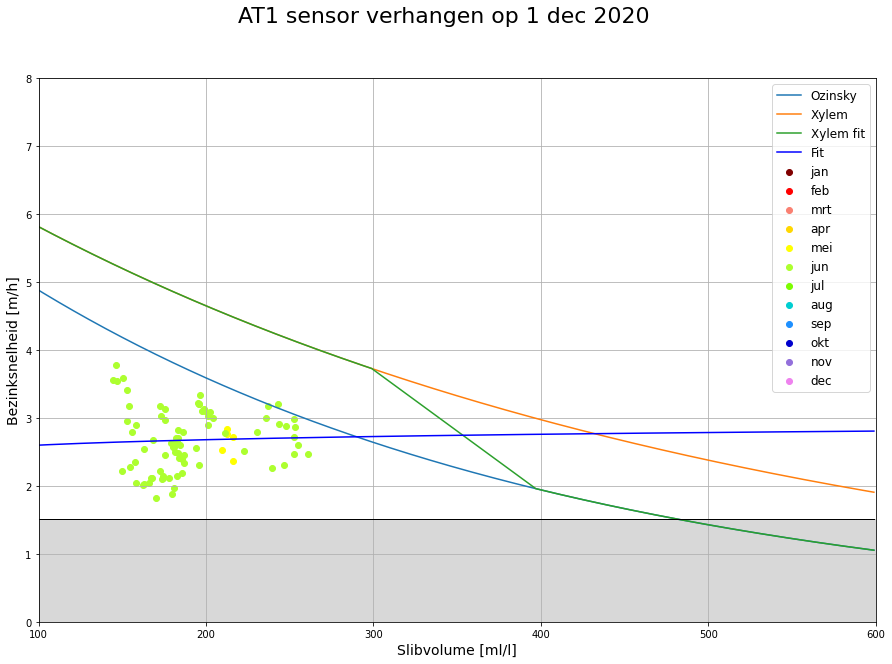

In [48]:

colors = {1:'maroon', 2:'red', 3: 'salmon', 4:'gold', 5:'yellow', 6:'greenyellow', 7:'lawngreen', 8: 'darkturquoise', 9: 'dodgerblue', 10: 'mediumblue',11: 'mediumpurple', 12: 'violet'}
legend = {1:"jan",2:"feb",3:"mrt",4:"apr",5:"mei",6:"jun",7:"jul",8:"aug",9:"sep",10:"okt",11:"nov",12:"dec"}
df1_sviplot = df1_sviplot.assign(Month = df1_sviplot.index.month)


fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1 sensor verhangen op 1 dec 2020",fontsize=22)
ax.set_xlim(100,600)
ax.set_ylim(0,8)
ax.set_xlabel("Slibvolume [ml/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
for i in range(12):
    ax.scatter(x=df1_sviplot[df1_sviplot["Month"]==i+1]["Slibvolume1"], y=df1_sviplot[df1_sviplot["Month"]==i+1]['Totale snelheid1'], color=colors[i+1], label = legend[i+1])

ax.plot(t, ozinsky(t, 120), label="Ozinsky")
ax.plot(t, xylem(t, 120), label="Xylem")
ax.plot(t, xylem_fit(t, 120), label="Xylem fit")
ax.plot(t, p(np.log(t)), "b-", label = "Fit")
ax.plot(t, min_snelheid(t), color="black", linewidth=1)
#plt.axvline(x=405, color="black", linewidth=1)

#plt.axvspan(405,600, color="grey", alpha=0.3)
plt.axhspan(0,1.52, color="grey", alpha=0.3)
# plt.text(320,5.5,"Operationeel window")
#plt.text(420,5.5,"Window bezinksnelheid hoog genoeg")

plt.legend(fontsize="12")
plt.grid(which='major', axis='both')
name = loc_submap + "\AT1_Slibvolume_Bezinksnelheid_thiotrix"
#plt.savefig(name)

In [49]:
# Logaritmische fit AT2
df2_nonan = df2_sviplot[df2_sviplot["Totale snelheid2"].notnull()]
x = np.array(df2_nonan["Slibvolume2"])
y = np.array(df2_nonan["Totale snelheid2"])
z = np.polyfit(np.log(x), y, 1.1)
p = np.poly1d(z)

C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\numpy\lib\polynomial.py:734: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


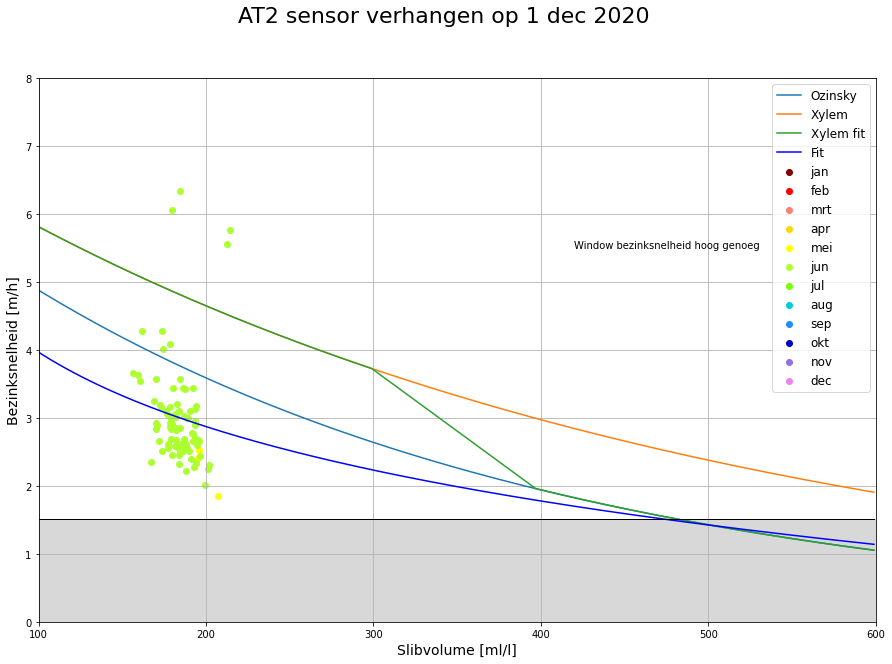

In [50]:
colors = {1:'maroon', 2:'red', 3: 'salmon', 4:'gold', 5:'yellow', 6:'greenyellow', 7:'lawngreen', 8: 'darkturquoise', 9: 'dodgerblue', 10: 'mediumblue',11: 'mediumpurple', 12: 'violet'}
legend = {1:"jan",2:"feb",3:"mrt",4:"apr",5:"mei",6:"jun",7:"jul",8:"aug",9:"sep",10:"okt",11:"nov",12:"dec"}
df2_sviplot = df2_sviplot.assign(Month = df2_sviplot.index.month)


fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2 sensor verhangen op 1 dec 2020",fontsize=22)
ax.set_xlim(100,600)
ax.set_ylim(0,8)
ax.set_xlabel("Slibvolume [ml/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
for i in range(12):
    ax.scatter(x=df2_sviplot[df2_sviplot["Month"]==i+1]["Slibvolume2"], y=df2_sviplot[df2_sviplot["Month"]==i+1]['Totale snelheid2'], color=colors[i+1], label = legend[i+1])

ax.plot(t, ozinsky(t, 120), label="Ozinsky")
ax.plot(t, xylem(t, 120), label="Xylem")
ax.plot(t, xylem_fit(t, 120), label="Xylem fit")
ax.plot(t, p(np.log(t)), "b-", label = "Fit")
ax.plot(t, min_snelheid(t), color="black", linewidth=1)
#plt.axvline(x=405, color="black", linewidth=1)

#plt.axvspan(405,600, color="grey", alpha=0.3)
plt.axhspan(0,1.52, color="grey", alpha=0.3)
#plt.text(320,5.5,"Operationeel window")
plt.text(420,5.5,"Window bezinksnelheid hoog genoeg")

plt.legend(fontsize="12")
plt.grid(which='major', axis='both')
name = loc_submap + "\AT2_Slibvolume_Bezinksnelheid_thiotrix"
#plt.savefig(name)

In [51]:
at1 = "mediumpurple"
at2 = "darkturquoise"
dwa = "red"
rwa = "dodgerblue"

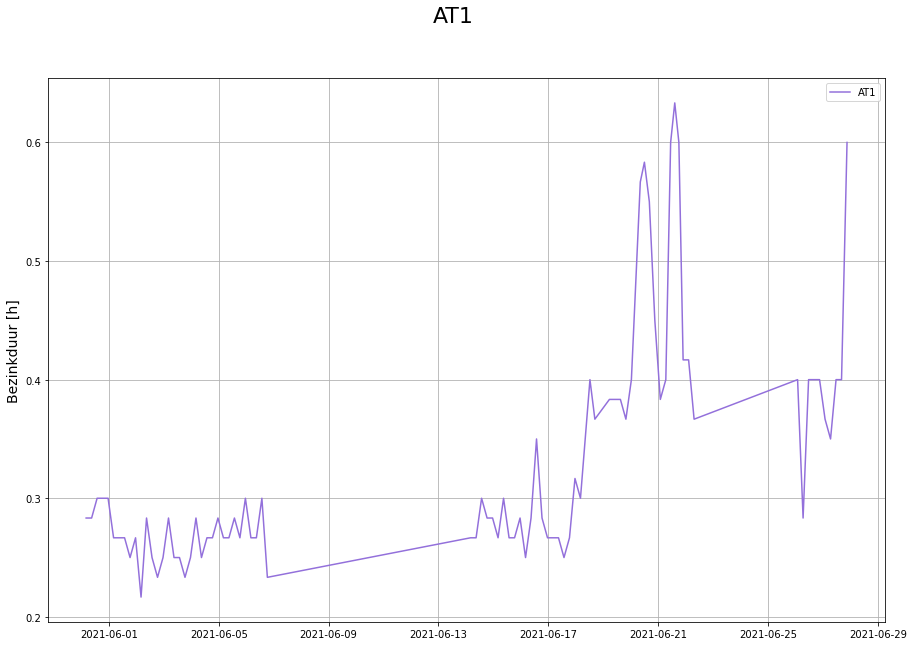

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Bezinkduur [h]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.index, df1_filter["Duur1"], color=at1, label="AT1")
plt.legend()
name = loc_map + "\AT1_Bezinkduur"
#plt.savefig(name)

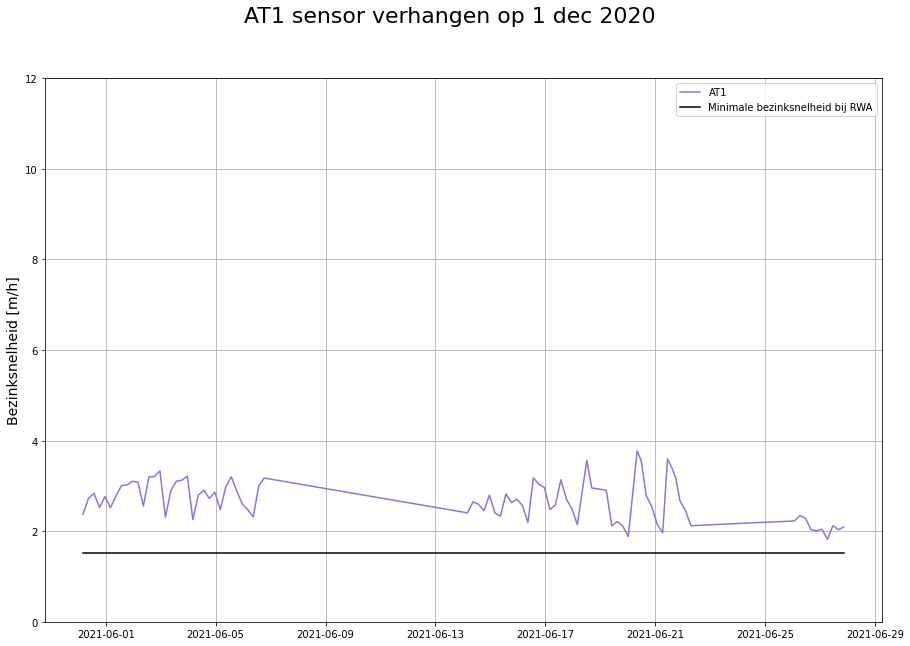

In [55]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1 sensor verhangen op 1 dec 2020",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.loc["2020-03-02 01:58:00":"2020-07-29 00:38:00"].index, df1_filter.loc["2020-03-02 01:58:00":"2020-07-29 00:38:00", "Totale snelheid1"], color=at1, label="AT1")
plt.plot(df1_filter.loc["2020-07-30 00:38:00":].index, df1_filter.loc["2020-07-30 00:38:00":, "Totale snelheid1"], color=at1)
#plt.plot(df1_filter.index, df1_filter["Totale snelheid1"], color=at1, label="AT1")
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend()
ax.set_ylim(0,12)
name = loc_submap + "\AT1_Bezinksnelheid"
#plt.savefig(name)

(0.0, 5.0)

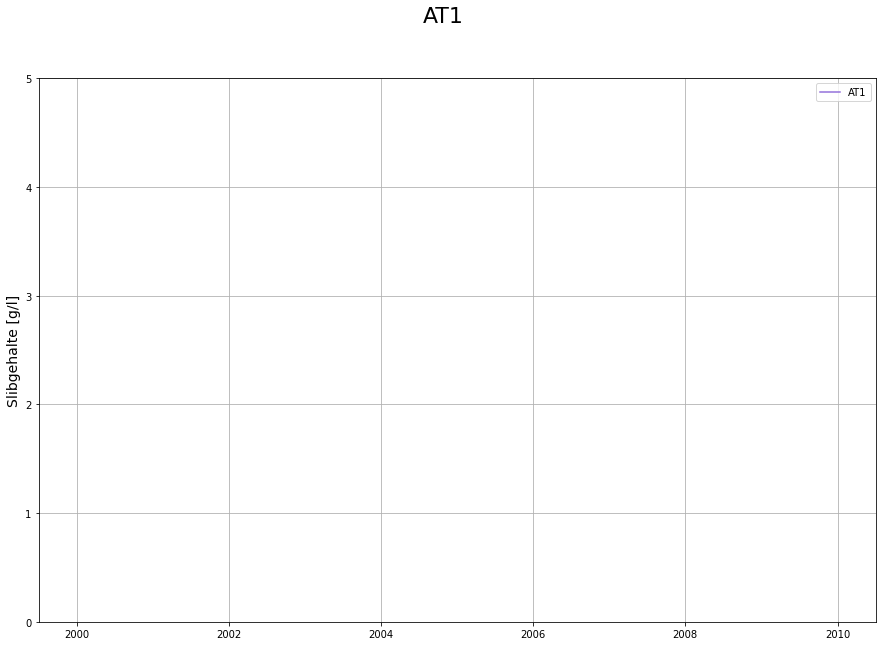

In [54]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Slibgehalte [g/l]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.loc["2020-04-17 00:00:00":"2020-07-29 00:38:00"].index, df1_filter.loc["2020-04-17 00:00:00":"2020-07-29 00:38:00", "Slibgehalte1"], color=at1, label="AT1")
plt.plot(df1_filter.loc["2020-07-30 00:38:00":"2021-03-31 23:59:00"].index, df1_filter.loc["2020-07-30 00:38:00":"2021-03-31 23:59:00", "Slibgehalte1"], color=at1)
plt.legend()
name = loc_map + "\AT1_Slibgehalte_apr_mrt"
ax.set_ylim(0,5)
#plt.savefig(name)

(0.0, 150.0)

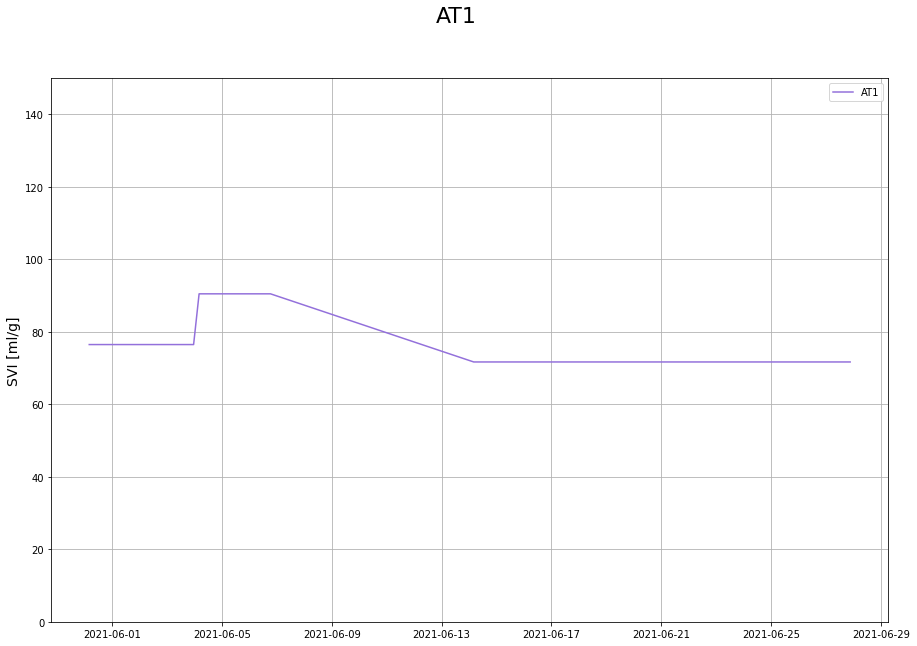

In [56]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("SVI [ml/g]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.index, df1_filter["SVI1"], color=at1, label="AT1")
plt.legend()
name = loc_map + "\AT1_SVI"
ax.set_ylim(0,150)
#plt.savefig(name)

(0.0, 500.0)

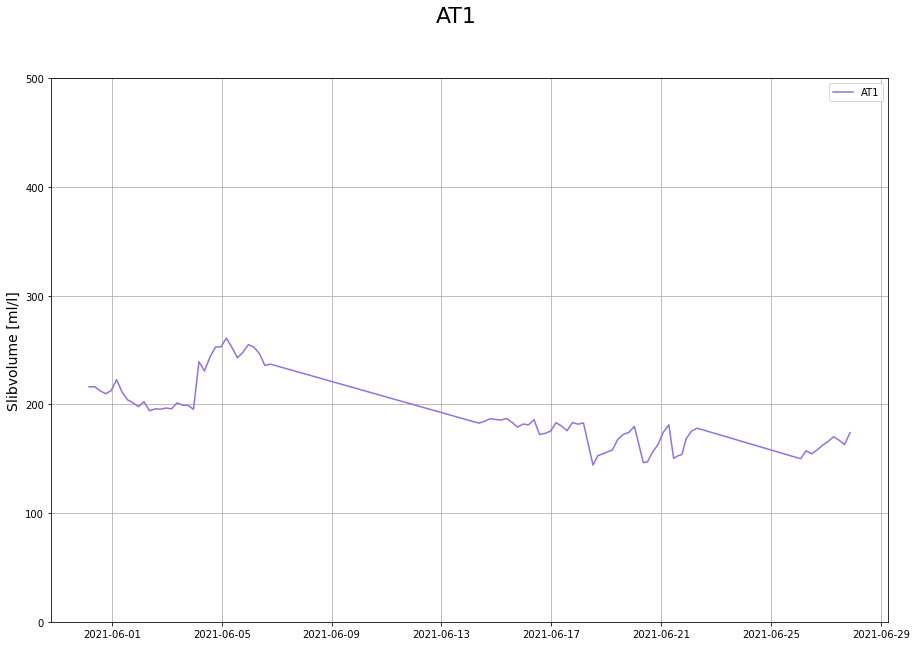

In [57]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_ylabel("Slibvolume [ml/l]", fontsize=14)
plt.grid(which='major', axis='both')
plt.plot(df1_filter.index, df1_filter["Slibvolume1"], color=at1, label="AT1")
plt.legend()
name = loc_map + "\AT1_Slibvolume"
ax.set_ylim(0,500)
#plt.savefig(name)

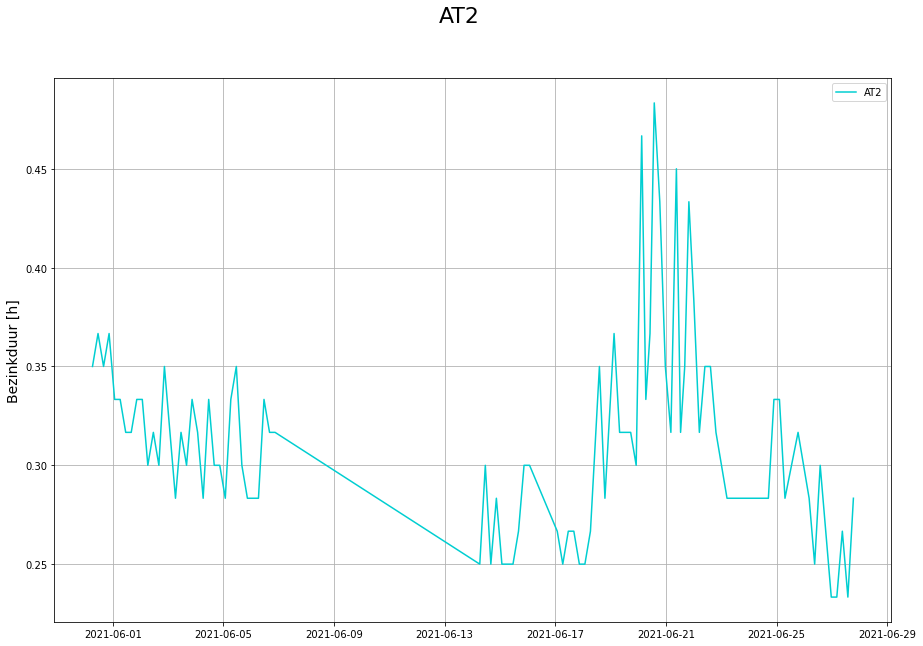

In [58]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Bezinkduur [h]", fontsize=14)
plt.plot(df2_filter.index, df2_filter["Duur2"], color = at2, label="AT2")
# ax.plot(df2_filter.index, min_snelheid(df2_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend()
# ax.set_ylim(0,12)
name = loc_map + "\AT2_Bezinkduur"
#plt.savefig(name)

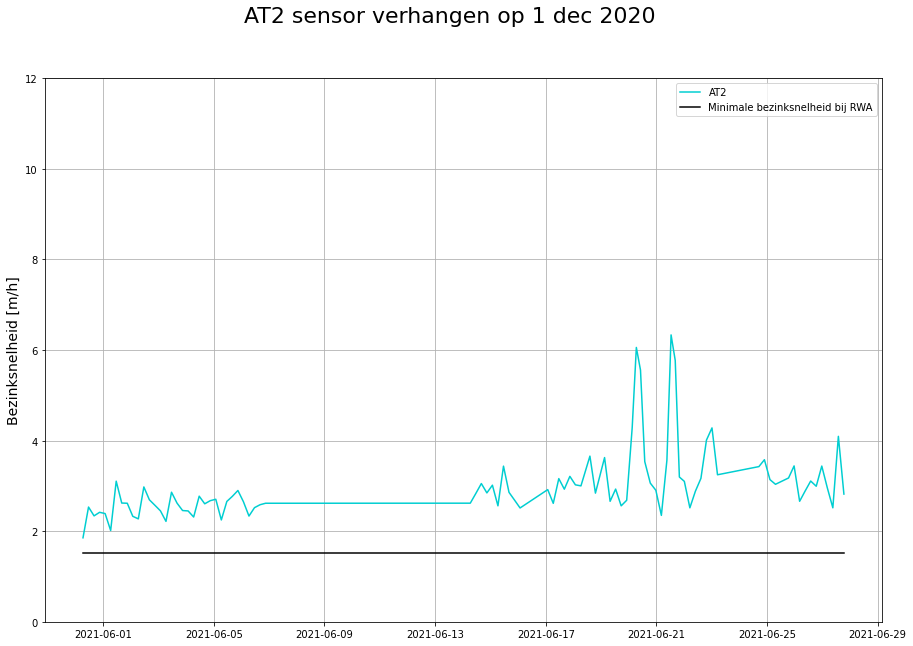

In [59]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2 sensor verhangen op 1 dec 2020",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
plt.plot(df2_filter.loc[:"2020-08-01"].index, df2_filter.loc[:"2020-08-01","Totale snelheid2"], color = at2, label="AT2")
plt.plot(df2_filter.loc["2020-08-10":].index, df2_filter.loc["2020-08-10":,"Totale snelheid2"], color = at2)
ax.plot(df2_filter.index, min_snelheid(df2_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend()
ax.set_ylim(0,12)
name = loc_submap + "\AT2_Bezinksnelheid"
#plt.savefig(name)

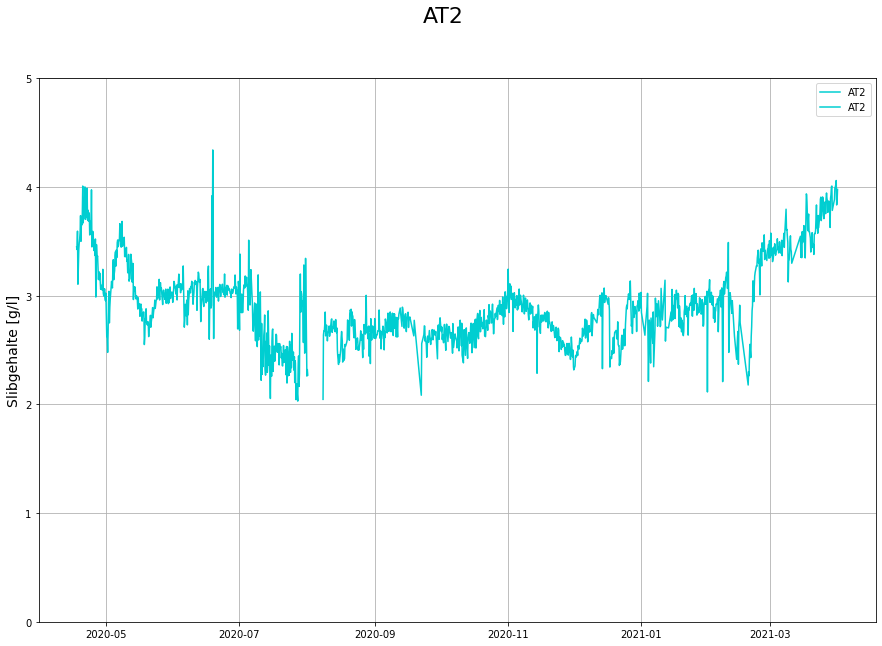

In [142]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Slibgehalte [g/l]", fontsize=14)
plt.plot(df2_filter.loc["2020-04-17 00:00:00":"2020-08-02 23:59:00"].index, df2_filter.loc["2020-04-17 00:00:00":"2020-08-02 23:59:00", "Slibgehalte2"], color = at2, label="AT2")
plt.plot(df2_filter.loc["2020-08-03 00:00:00":"2021-03-31 23:59:00"].index, df2_filter.loc["2020-08-03 00:00:00":"2021-03-31 23:59:00", "Slibgehalte2"], color = at2, label="AT2")
plt.grid(which='major', axis='both')
plt.legend()
ax.set_ylim(0,5)
name = loc_map + "\AT2_Slibgehalte_apr_mrt"
plt.savefig(name)

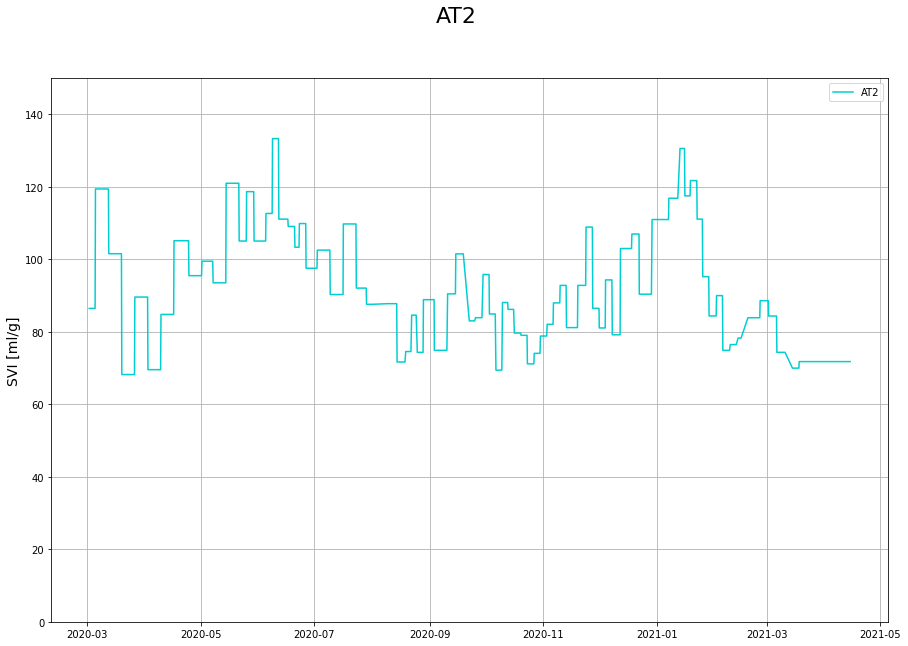

In [129]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("SVI [ml/g]", fontsize=14)
plt.plot(df2_filter.index, df2_filter["SVI2"], color = at2, label="AT2")
# ax.plot(df2_filter.index, min_snelheid(df2_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend()
ax.set_ylim(0,150)
name = loc_map + "\AT2_SVI"
plt.savefig(name)

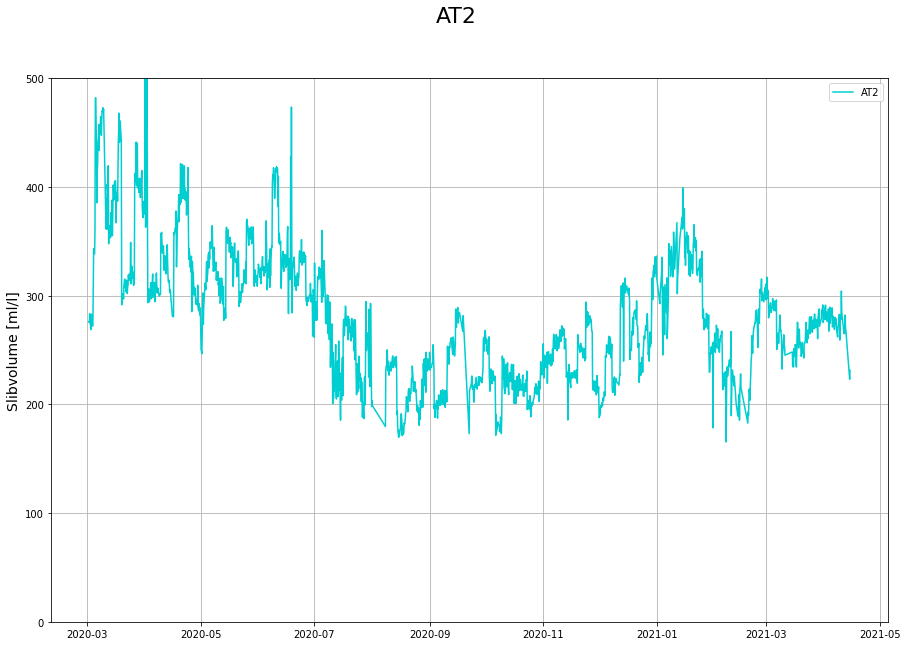

In [130]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Slibvolume [ml/l]", fontsize=14)
plt.plot(df2_filter.index, df2_filter["Slibvolume2"], color = at2, label="AT2")
# ax.plot(df2_filter.index, min_snelheid(df2_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend()
ax.set_ylim(0,500)
name = loc_map + "\AT2_Slibvolume"
plt.savefig(name)

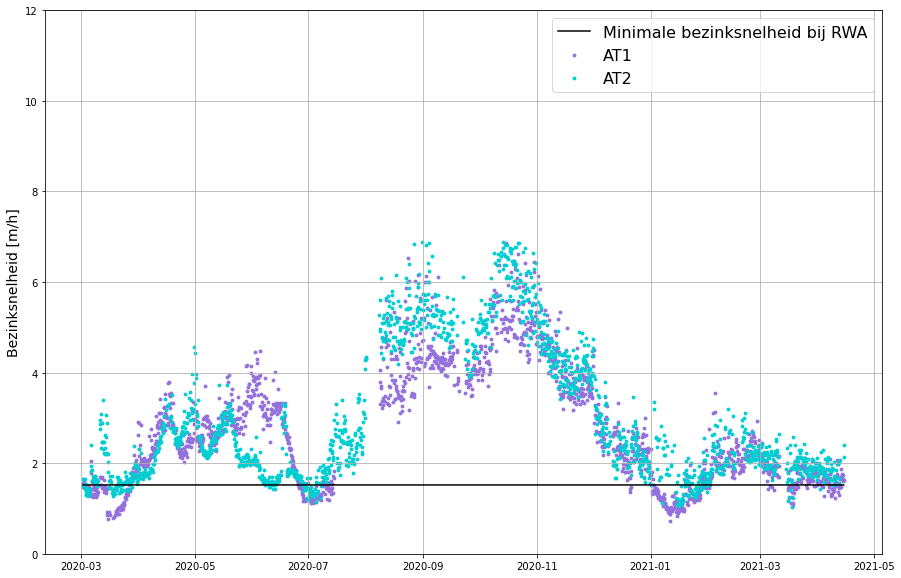

In [131]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_filter.index, df1_filter["Totale snelheid1"], label = "AT1",s=8, color=at1)
plt.scatter(df2_filter.index, df2_filter["Totale snelheid2"], label = "AT2", s=8, color=at2)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend(fontsize="16")
name = loc_submap + "\Bezinksnelheid"
plt.savefig(name)

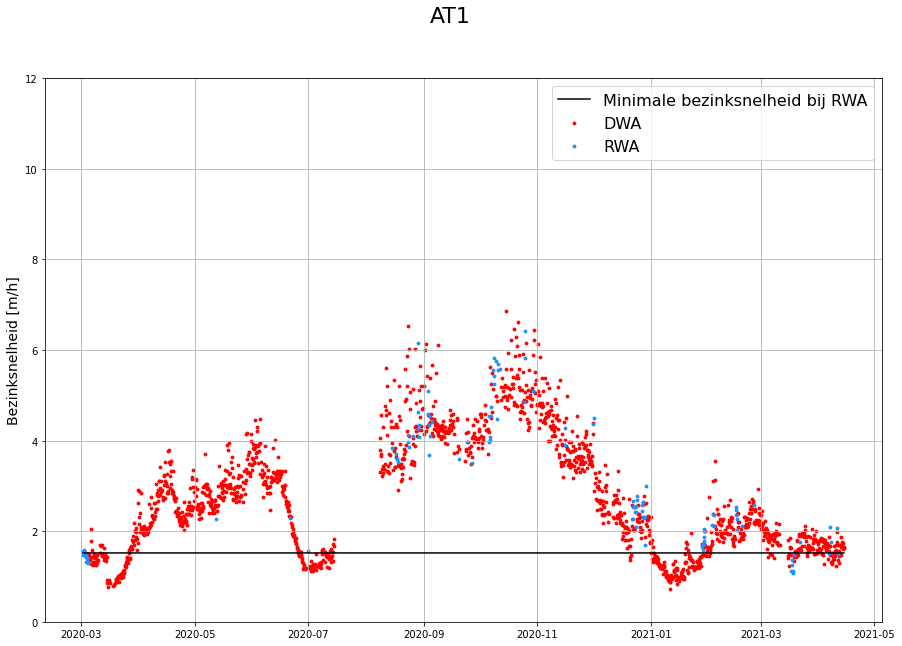

In [132]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)
df1_DWA = df1_filter[df1_filter["Cyclusduur1"] > cut]
df1_RWA = df1_filter[df1_filter["Cyclusduur1"] < cut]

fig, ax = plt.subplots(figsize=(15,10))
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
fig.suptitle("AT1",fontsize=22)
ax.set_ylim(0,12)
plt.scatter(df1_DWA.index, df1_DWA["Totale snelheid1"], label = "DWA",s=8,  color=dwa)
plt.scatter(df1_RWA.index, df1_RWA["Totale snelheid1"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.grid(which='major', axis='both')
plt.legend(fontsize="16")
name = loc_submap + "\Cyclusduur_Bezinksnelheid_AT1"
plt.savefig(name)

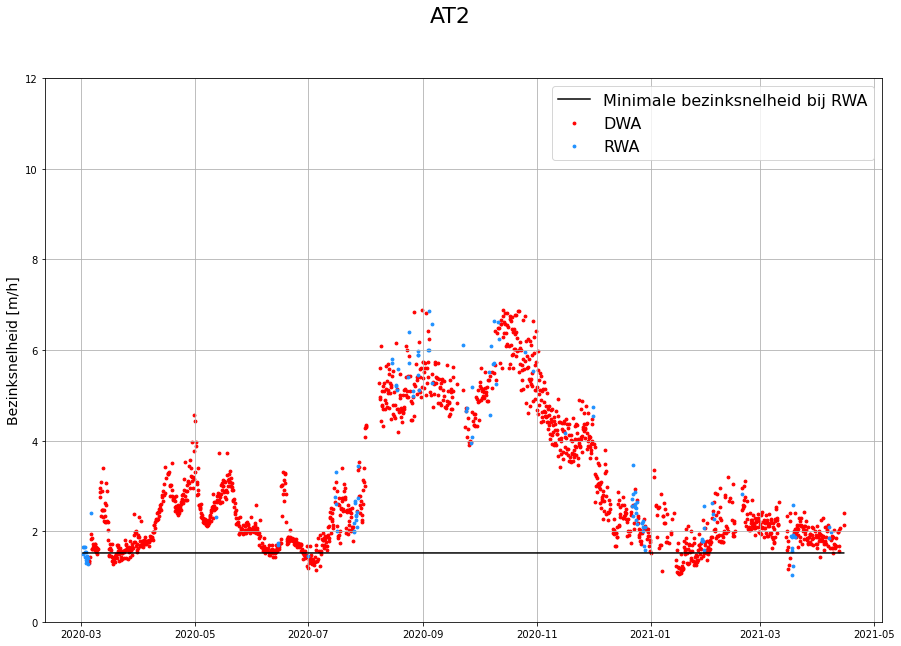

In [133]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)
df2_DWA = df2_filter[df2_filter["Cyclusduur2"] > cut]
df2_RWA = df2_filter[df2_filter["Cyclusduur2"] < cut]

fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_DWA.index, df2_DWA["Totale snelheid2"], label = "DWA",s=8, color=dwa)
plt.scatter(df2_RWA.index, df2_RWA["Totale snelheid2"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter.index, min_snelheid(df1_filter.index), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
name = loc_submap + "\Cyclusduur_Bezinksnelheid_AT2"
plt.savefig(name)

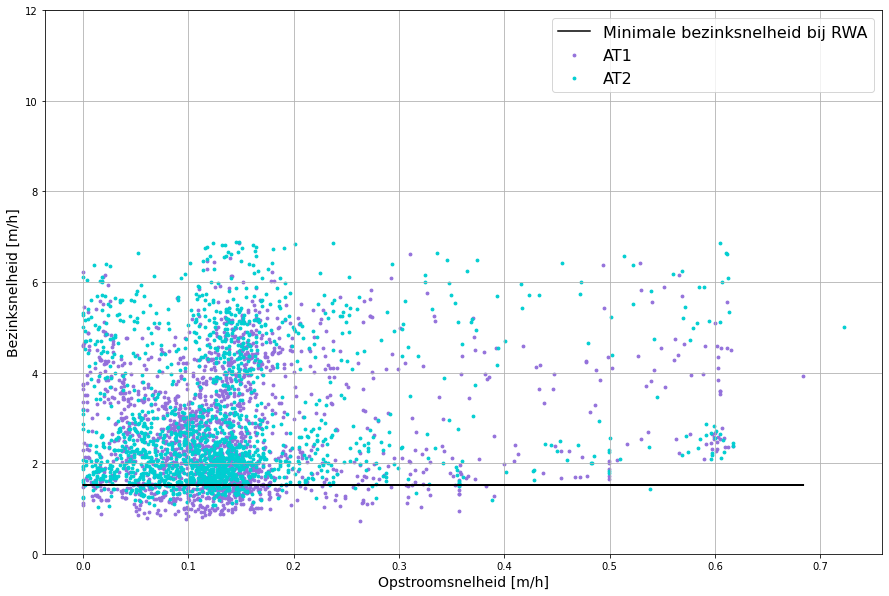

In [134]:
# DWA versus RWA
cut = datetime.timedelta(hours=4)

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_filter["Opstroomsnelheid1"], df1_filter["Totale snelheid1"], label = "AT1",s=8, color=at1)
plt.scatter(df2_filter["Opstroomsnelheid2"], df2_filter["Totale snelheid2"], label = "AT2", s=8, color=at2)
ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
name = loc_submap + "\Opstroomsnelheid_Bezinksnelheid"
plt.savefig(name)

C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\ProgramData\Miniconda3\envs\standaardpy\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


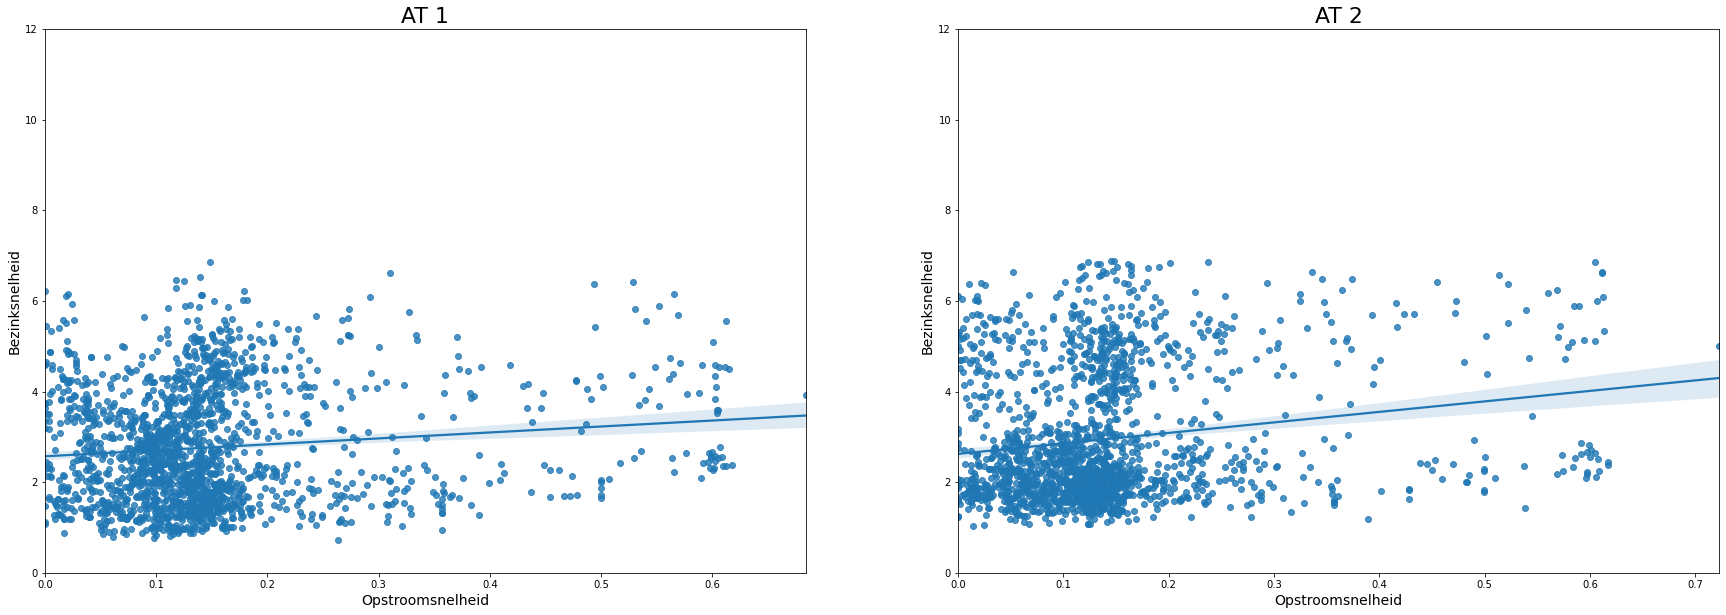

In [135]:
import seaborn as sns
fix, axs = plt.subplots(ncols=2, figsize=(30,10))
sns.regplot(df1_filter["Opstroomsnelheid1"], df1_filter["Totale snelheid1"], ax=axs[0])
axs[0].set_ylim(0,12)
axs[0].set_title("AT 1", fontsize=22)
axs[0].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[0].set_ylabel("Bezinksnelheid", fontsize=14)
sns.regplot(df2_filter["Opstroomsnelheid2"], df2_filter["Totale snelheid2"], ax=axs[1])
axs[1].set_ylim(0,12)
axs[1].set_title("AT 2", fontsize=22)
axs[1].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[1].set_ylabel("Bezinksnelheid", fontsize=14)
name = loc_submap + "\Regressie_Opstroomsnelheid_Bezinksnelheid"
plt.savefig(name)


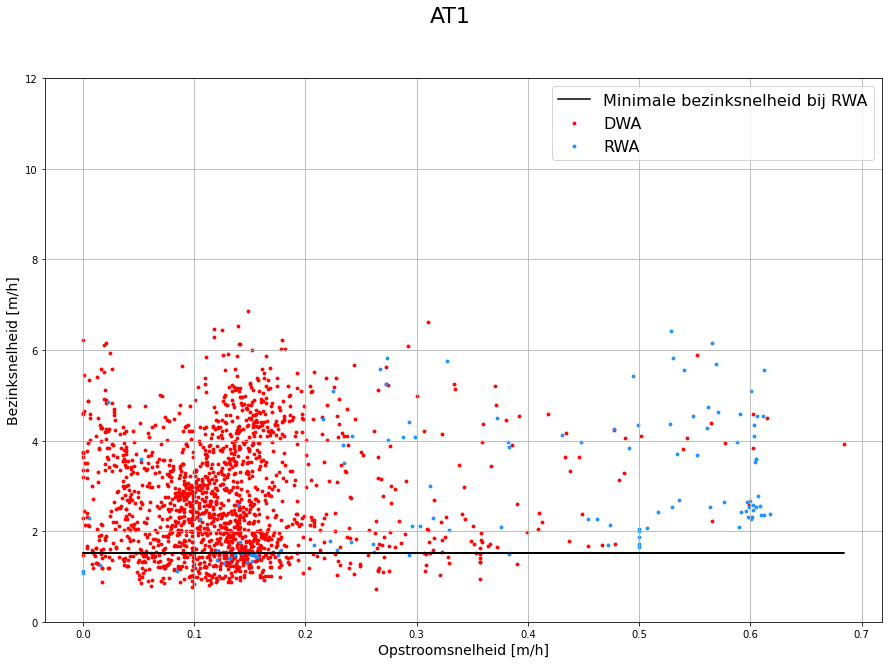

In [136]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT1",fontsize=22)
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_DWA["Opstroomsnelheid1"], df1_DWA["Totale snelheid1"], label = "DWA",s=8, color=dwa)
plt.scatter(df1_RWA["Opstroomsnelheid1"], df1_RWA["Totale snelheid1"], label = "RWA", s=8, color=rwa)
ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
name = loc_submap + "\Cyclusduur_Opstroomsnelheid_Bezinksnelheid_AT1"
plt.savefig(name)

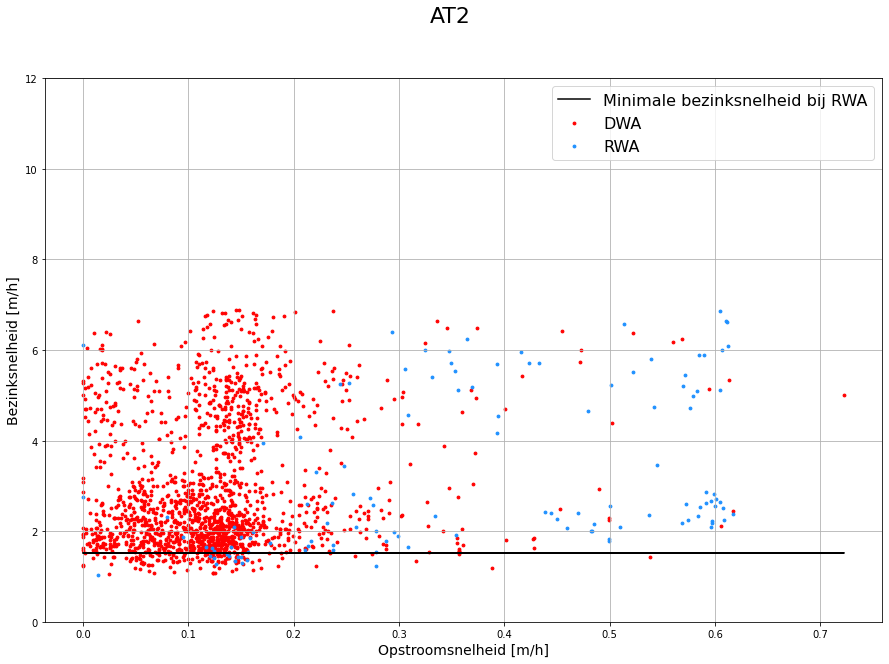

In [137]:
fig, ax = plt.subplots(figsize=(15,10))
fig.suptitle("AT2",fontsize=22)
ax.set_xlabel("Opstroomsnelheid [m/h]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_DWA["Opstroomsnelheid2"], df2_DWA["Totale snelheid2"], label = "DWA",s=8, color=dwa)
plt.scatter(df2_RWA["Opstroomsnelheid2"], df2_RWA["Totale snelheid2"], label = "RWA", s=8, color=rwa)
ax.plot(df2_filter["Opstroomsnelheid2"], min_snelheid(df2_filter["Opstroomsnelheid2"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
plt.grid(which='major', axis='both')
name = loc_submap + "\Cyclusduur_Opstroomsnelheid_Bezinksnelheid_AT2"
plt.savefig(name)

In [549]:
df1_filter.head()

Begin_cyclus1     Cyclusduur1  Slibgehalte1  \
2020-03-02 01:58:00  2020-03-01 23:52:00 0 days 03:37:00         3.183   
2020-03-02 05:35:00  2020-03-02 03:29:00 0 days 03:36:00         3.351   
2020-03-02 09:11:00  2020-03-02 07:05:00 0 days 03:36:00         3.308   
2020-03-02 12:47:00  2020-03-02 10:41:00 0 days 03:36:00         3.120   
2020-03-03 03:10:00  2020-03-03 01:04:00 0 days 03:37:00         3.214   

                     Waterhoogte1  Opstroomsnelheid1     Duur1  Level sensor1  \
2020-03-02 01:58:00         4.710           0.151222  1.100000           3.25   
2020-03-02 05:35:00         4.658           0.120089  0.983333           3.25   
2020-03-02 09:11:00         4.630           0.177826  0.983333           3.25   
2020-03-02 12:47:00         4.895           0.292851  1.400000           3.25   
2020-03-03 03:10:00         4.859           0.261338  1.250000           3.25   

                     delta_h1    SVI1  Snelheid1  Totale snelheid1  \
2020-03-02 01:58:00     1.460  81.913   1.327273          1.478495   
2020-03-02 05:35:00     1.408  81.913   1.431864          1.551953   
2020-03-02 09:11:00     1.380  81.913   1.403390          1.581216   
2020-03-02 12:47:00     1.645  81.913   1.175000          1.467851   
2020-03-03 03:10:00     1.609  81.913   1.287200          1.548538   

                     Slibvolume1    Reactietijd1     Start_bezinken1  \
2020-03-02 01:58:00   260.729079 0 days 02:06:00 2020-03-02 01:58:00   
2020-03-02 05:35:00   274.490463 0 days 02:06:00 2020-03-02 05:35:00   
2020-03-02 09:11:00   270.968204 0 days 02:06:00 2020-03-02 09:11:00   
2020-03-02 12:47:00   255.568560 0 days 02:06:00 2020-03-02 12:47:00   
2020-03-03 03:10:00   263.268382 0 days 02:06:00 2020-03-03 03:10:00   

                    Cyclusduur1_str  
2020-03-02 01:58:00        03:37:00  
2020-03-02 05:35:00        03:36:00  
2020-03-02 09:11:00        03:36:00  
2020-03-02 12:47:00        03:36:00  
2020-03-03 03:10:00        03:37:00

In [241]:
df1_svilaag = df1_filter[(df1_filter["SVI1"]<80) & (df1_filter["Slibgehalte1"]>=2)]
df1_svimiddel = df1_filter[(df1_filter["SVI1"]>=80) & (df1_filter["SVI1"]<100) & (df1_filter["Slibgehalte1"]>=2)]
df1_svihoog = df1_filter[(df1_filter["SVI1"]>=100) & (df1_filter["Slibgehalte1"]>=2)]

In [242]:
df2_svilaag = df2_filter[(df2_filter["SVI2"]<80) & (df2_filter["Slibgehalte2"]>=2)]
df2_svimiddel = df2_filter[(df2_filter["SVI2"]>=80) & (df2_filter["SVI2"]<100) & (df2_filter["Slibgehalte2"]>=2)]
df2_svihoog = df2_filter[(df2_filter["SVI2"]>=100) & (df2_filter["Slibgehalte2"]>=2)]

In [254]:
df1_svifit = pd.concat([df1_svilaag, df1_svimiddel, df1_svihoog])
df2_svifit = pd.concat([df2_svilaag, df2_svimiddel, df2_svihoog])

In [269]:
t = np.arange(2,5,0.01)

# # Logaritmische fit
# df1_svifit = df1_svifit[df1_svifit["Totale snelheid1"].notnull()]
# x = np.array(df1_svifit["Slibgehalte1"])
# y = np.array(df1_svifit["Totale snelheid1"])
# z = np.polyfit(np.log(x), y, 1)
# p = np.poly1d(z)

In [270]:
def xylem(t, svi_ref):
    return(7.27*np.exp(-(0.0281+0.002*svi_ref)*t))

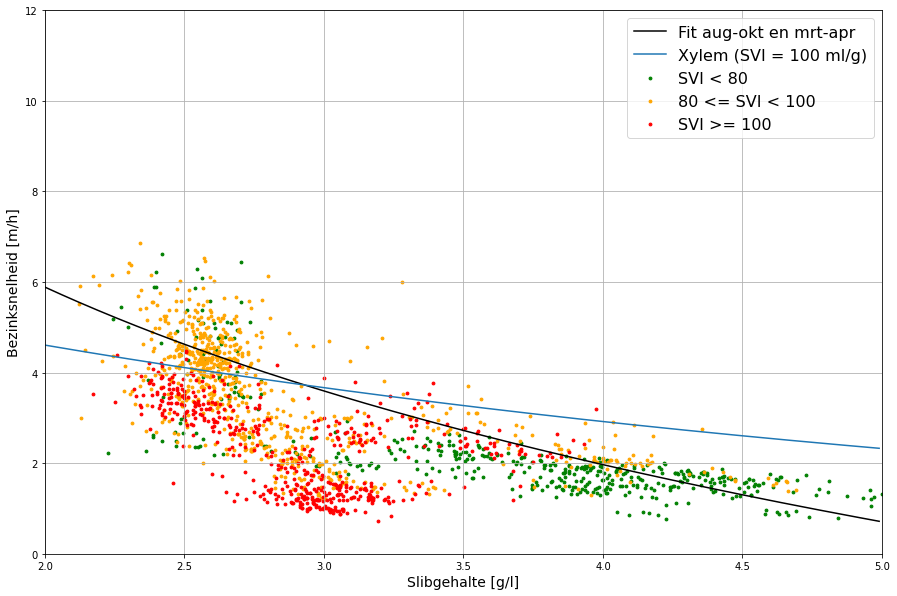

In [282]:
# DWA versus RWA
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Slibgehalte [g/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_svilaag["Slibgehalte1"], df1_svilaag["Totale snelheid1"], label = "SVI < 80",s=8, color="green")
plt.scatter(df1_svimiddel["Slibgehalte1"], df1_svimiddel["Totale snelheid1"], label = "80 <= SVI < 100",s=8, color="orange")
plt.scatter(df1_svihoog["Slibgehalte1"], df1_svihoog["Totale snelheid1"], label = "SVI >= 100",s=8, color="red")
ax.plot(t, p(np.log(t)), "k-", label = "Fit aug-okt en mrt-apr")
ax.plot(t, xylem(t, 100), label="Xylem (SVI = 100 ml/g)")

#ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
ax.set_xlim(2,5)
plt.grid(which='major', axis='both')
name = loc_submap + "\Slibgehalte_Bezinksnelheid"
plt.savefig(name)

In [258]:
# # Logaritmische fit
# df2_svifit = df2_svifit[df2_svifit["Totale snelheid2"].notnull()]
# x = np.array(df2_svifit["Slibgehalte2"])
# y = np.array(df2_svifit["Totale snelheid2"])
# z = np.polyfit(np.log(x), y, 1)
# p = np.poly1d(z)

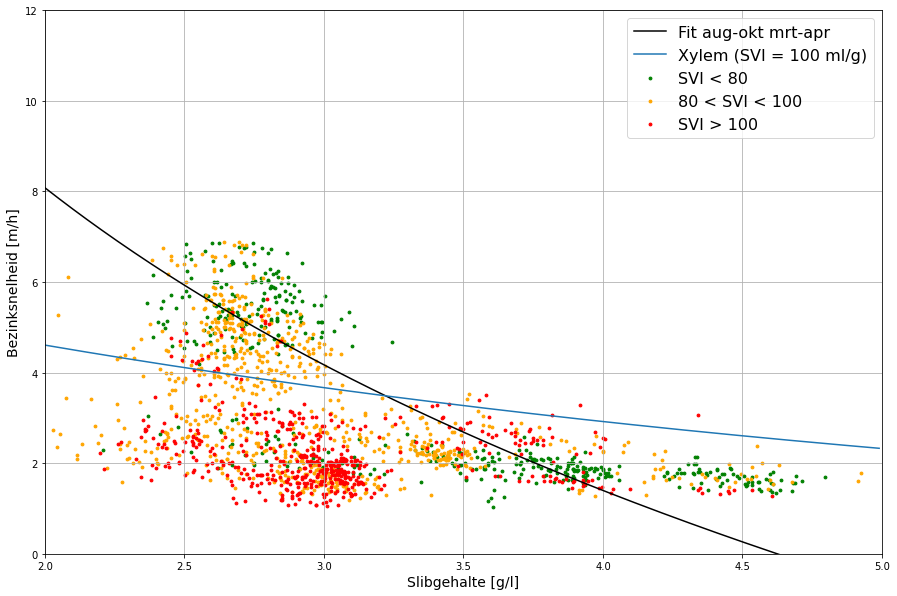

In [278]:
# DWA versus RWA
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Slibgehalte [g/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_svilaag["Slibgehalte2"], df2_svilaag["Totale snelheid2"], label = "SVI < 80",s=8, color="green")
plt.scatter(df2_svimiddel["Slibgehalte2"], df2_svimiddel["Totale snelheid2"], label = "80 < SVI < 100",s=8, color="orange")
plt.scatter(df2_svihoog["Slibgehalte2"], df2_svihoog["Totale snelheid2"], label = "SVI > 100",s=8, color="red")
ax.plot(t, p(np.log(t)), "k-", label = "Fit aug-okt mrt-apr")
#ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
ax.plot(t, xylem(t, 100), label="Xylem (SVI = 100 ml/g)")
plt.legend(fontsize="16")
ax.set_xlim(2,5)
plt.grid(which='major', axis='both')
name = loc_submap + "\Slibgehalte_Bezinksnelheid_AT2"
plt.savefig(name)

In [266]:
summer_start = "2020-08-01"; summer_end = "2020-10-31"
winter_start = "2021-03-01"; winter_end = "2021-04-30"

In [280]:
# Logaritmische fit
df1_svifit_nt = pd.concat([df1_svifit.loc[summer_start:summer_end], df1_svifit.loc[winter_start:winter_end]])
x = np.array(df1_svifit_nt["Slibgehalte1"])
y = np.array(df1_svifit_nt["Totale snelheid1"])
z = np.polyfit(np.log(x), y, 1)
p = np.poly1d(z)

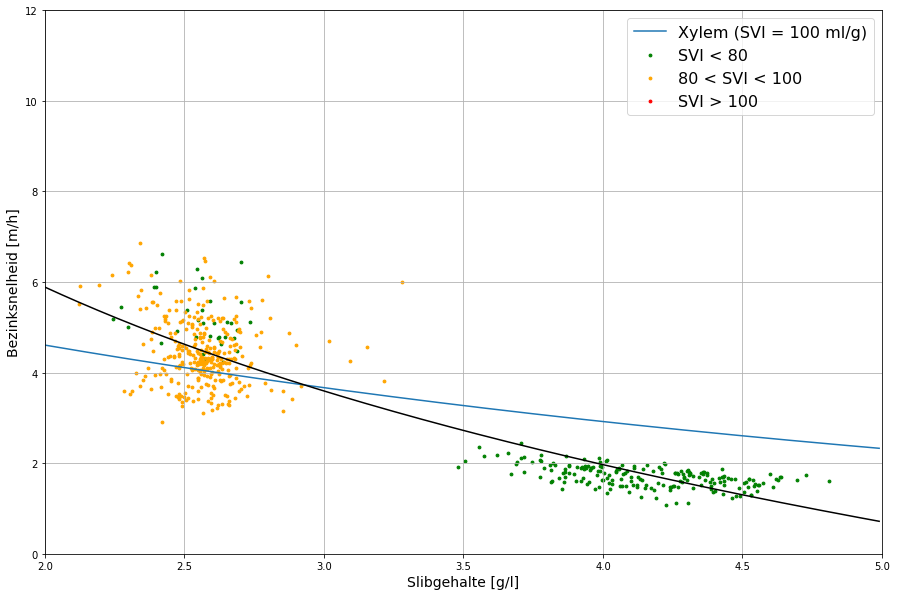

In [281]:

# DWA versus RWA
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Slibgehalte [g/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df1_svilaag.loc[summer_start:summer_end, "Slibgehalte1"], df1_svilaag.loc[summer_start:summer_end, "Totale snelheid1"], label = "SVI < 80",s=8, color="green")
plt.scatter(df1_svimiddel.loc[summer_start:summer_end, "Slibgehalte1"], df1_svimiddel.loc[summer_start:summer_end, "Totale snelheid1"], label = "80 < SVI < 100",s=8, color="orange")
plt.scatter(df1_svihoog.loc[summer_start:summer_end, "Slibgehalte1"], df1_svihoog.loc[summer_start:summer_end, "Totale snelheid1"], label = "SVI > 100",s=8, color="red")
plt.scatter(df1_svilaag.loc[winter_start:winter_end, "Slibgehalte1"], df1_svilaag.loc[winter_start:winter_end, "Totale snelheid1"],s=8, color="green")
# plt.scatter(df1_svimiddel.loc[winter_start:winter_end, "Slibgehalte1"], df1_svimiddel.loc[winter_start:winter_end, "Totale snelheid1"],s=8, color="orange")
plt.scatter(df1_svihoog.loc[winter_start:winter_end, "Slibgehalte1"], df1_svihoog.loc[winter_start:winter_end, "Totale snelheid1"],s=8, color="red")
# ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
ax.plot(t, xylem(t, 100), label="Xylem (SVI = 100 ml/g)")
plt.legend(fontsize="16")
ax.plot(t, p(np.log(t)), "k-", label = "Fit")
ax.set_xlim(2,5)
plt.grid(which='major', axis='both')
name = loc_submap + "\Slibgehalte_Bezinksnelheid_window"
plt.savefig(name)

In [274]:
# Logaritmische fit
df2_svifit_nt = pd.concat([df2_svifit.loc[summer_start:summer_end], df2_svifit.loc[winter_start:winter_end]])
x = np.array(df2_svifit_nt["Slibgehalte2"])
y = np.array(df2_svifit_nt["Totale snelheid2"])
z = np.polyfit(np.log(x), y, 1)
p = np.poly1d(z)

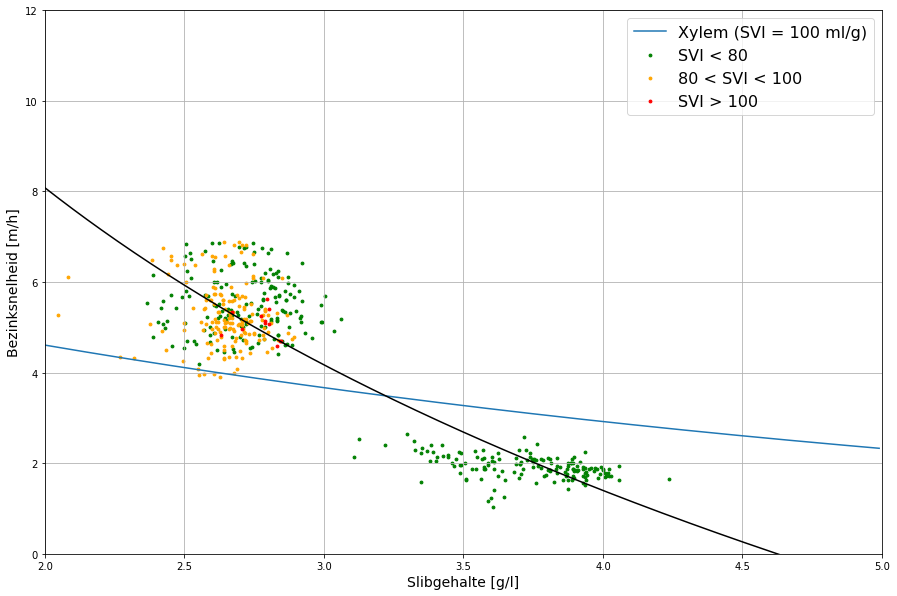

In [279]:
summer_start = "2020-08-01"; summer_end = "2020-10-31"
winter_start = "2021-03-01"; winter_end = "2021-04-30"
# DWA versus RWA
fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Slibgehalte [g/l]", fontsize=14)
ax.set_ylabel("Bezinksnelheid [m/h]", fontsize=14)
ax.set_ylim(0,12)
plt.scatter(df2_svilaag.loc[summer_start:summer_end, "Slibgehalte2"], df2_svilaag.loc[summer_start:summer_end, "Totale snelheid2"], label = "SVI < 80",s=8, color="green")
plt.scatter(df2_svimiddel.loc[summer_start:summer_end, "Slibgehalte2"], df2_svimiddel.loc[summer_start:summer_end, "Totale snelheid2"], label = "80 < SVI < 100",s=8, color="orange")
plt.scatter(df2_svihoog.loc[summer_start:summer_end, "Slibgehalte2"], df2_svihoog.loc[summer_start:summer_end, "Totale snelheid2"], label = "SVI > 100",s=8, color="red")
plt.scatter(df2_svilaag.loc[winter_start:winter_end, "Slibgehalte2"], df2_svilaag.loc[winter_start:winter_end, "Totale snelheid2"],s=8, color="green")
# plt.scatter(df2_svimiddel.loc[winter_start:winter_end, "Slibgehalte2"], df2_svimiddel.loc[winter_start:winter_end, "Totale snelheid2"],s=8, color="orange")
plt.scatter(df2_svihoog.loc[winter_start:winter_end, "Slibgehalte2"], df2_svihoog.loc[winter_start:winter_end, "Totale snelheid2"],s=8, color="red")
ax.plot(t, xylem(t, 100), label="Xylem (SVI = 100 ml/g)")
# ax.plot(df1_filter["Opstroomsnelheid1"], min_snelheid(df1_filter["Opstroomsnelheid1"]), label="Minimale bezinksnelheid bij RWA", color="black")
plt.legend(fontsize="16")
ax.plot(t, p(np.log(t)), "k-", label = "Fit")
ax.set_xlim(2,5)
plt.grid(which='major', axis='both')
name = loc_submap + "\Slibgehalte_Bezinksnelheid_window_AT2"
plt.savefig(name)

Slibproductie


In [167]:
df[["7022 SSI_FT143_PW","7022 SSI_QT142_PW"]].head()

7022 SSI_FT143_PW  7022 SSI_QT142_PW
2020-02-07 14:55:00                0.0              6.027
2020-02-07 14:56:00                0.0              6.027
2020-02-07 14:57:00                0.0              6.027
2020-02-07 14:58:00                0.0              6.027
2020-02-07 14:59:00                0.0              6.027

In [168]:
davg = df[["7022 SSI_FT143_PW","7022 SSI_QT142_PW"]].resample('D').mean()

In [169]:
davg["Slibproductie"] = davg["7022 SSI_FT143_PW"]*davg["7022 SSI_QT142_PW"]*10*24

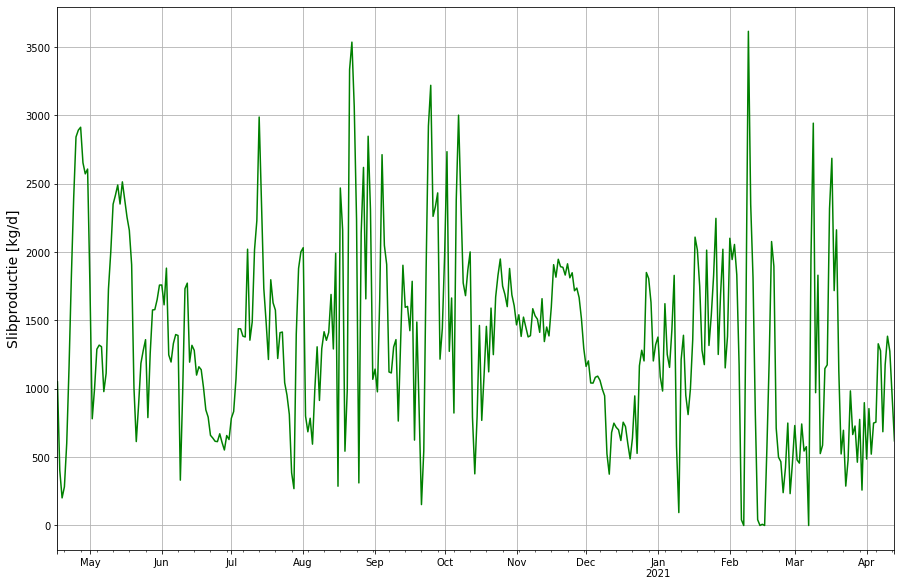

In [170]:
fix, ax = plt.subplots(figsize=(15,10))
fig.suptitle("Slibproductie",fontsize=22)
ax.set_ylabel("Slibproductie [kg/d]", fontsize=14)
davg.loc["2020-04-17":"2021-04-13","Slibproductie"].plot(color="green")
plt.grid(which='major', axis='both')
name = loc_map + "\Slibproductie"
plt.savefig(name)

In [171]:
davg.to_excel(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\OWT 3.4\Slibproductie_15_apr_2021.xlsx")

Integratie debiet vergelijking met waterhoogte

In [120]:
# select small part for testing
# df1_sep = df1_filter[(df1_filter.index>="2020-09-01")&(df1_filter.index<"2020-10-01")]
df1_sep = df1_filter[(df1_filter.index>="2020-09-|01")]
df2_sep = df2_filter[(df2_filter.index>="2020-09-01")]

TypeError: Invalid comparison between dtype=datetime64[ns] and str

In [ ]:
watersensor = []
debiettoename = []
at1_open = []
at2_open = []
begin = []
eind = []

for index, row in df1_sep.iterrows():
    begin_index = row["Begin_cyclus1"]
    eind_index = row["Start_bezinken1"] + datetime.timedelta(minutes=row["Duur1"]*60)
    if df.loc[begin_index,"7009 AT_P130_AS"] > 1:

        for i in range(30): 
            begin_index = str(pd.to_datetime(begin_index) + datetime.timedelta(minutes=1))
            
            if df.loc[begin_index,"7009 AT_P130_AS"]<1:
                break
            else: 
                continue

    if df.loc[eind_index,"7009 AT_P130_AS"] > 1:

        for i in range(70): 
            eind_index = eind_index - datetime.timedelta(minutes=1)
            
                        
            if df.loc[eind_index,"7009 AT_P130_AS"]<1:
                break
            else: 
                continue        

    start_wn = df.loc[begin_index, "7009 AT_LT114_AM"]
    eind_wn = df.loc[eind_index, "7009 AT_LT114_AM"]
    watersensor.append(eind_wn-start_wn)
    debiettoename.append(df.loc[begin_index:eind_index, "Opstroomsnelheid1"].sum()/60)
    at1_open.append(df.loc[begin_index, "7006 VW_A150_O"])
    at2_open.append(df.loc[begin_index, "7006 VW_A250_O"])
    begin.append(begin_index)
    eind.append(eind_index)

df1_sep.loc[:, "Watersensor1"] = pd.Series(watersensor, index=df1_sep.index)
df1_sep.loc[:, "Debiettoename1"] = pd.Series(debiettoename, index=df1_sep.index)
df1_sep.loc[:, "AT1_open"] = pd.Series(at1_open, index=df1_sep.index)
df1_sep.loc[:, "AT2_open"] = pd.Series(at2_open, index=df1_sep.index)
df1_sep.loc[:, "Begin"] = pd.Series(begin, index=df1_sep.index)
df1_sep.loc[:, "Eind"] = pd.Series(eind, index=df1_sep.index)

df1_sep.loc[:, "Hoogteverschil1"] = df1_sep["Debiettoename1"] - df1_sep["Watersensor1"]

In [ ]:
watersensor = []
debiettoename = []
at1_open = []
at2_open = []
begin = []
eind = []

for index, row in df2_sep.iterrows():
    begin_index = row["Begin_cyclus2"]
    eind_index = row["Start_bezinken2"] + datetime.timedelta(minutes=row["Duur2"]*60)
    if df.loc[begin_index,"7010 AT_P130_AS"] > 1:

        for i in range(30): 
            begin_index = str(pd.to_datetime(begin_index) + datetime.timedelta(minutes=1))
            
            if df.loc[begin_index,"7010 AT_P130_AS"]<1:
                break
            else: 
                continue

    if df.loc[eind_index,"7010 AT_P130_AS"] > 1:

        for i in range(70): 
            eind_index = eind_index - datetime.timedelta(minutes=1)
            
                        
            if df.loc[eind_index,"7010 AT_P130_AS"]<1:
                break
            else: 
                continue        

    start_wn = df.loc[begin_index, "7010 AT_LT114_AM"]
    eind_wn = df.loc[eind_index, "7010 AT_LT114_AM"]
    watersensor.append(eind_wn-start_wn)
    debiettoename.append(df.loc[begin_index:eind_index, "Opstroomsnelheid2"].sum()/60)
    at1_open.append(df.loc[begin_index, "7006 VW_A150_O"])
    at2_open.append(df.loc[begin_index, "7006 VW_A250_O"])
    begin.append(begin_index)
    eind.append(eind_index)

df2_sep.loc[:, "Watersensor2"] = pd.Series(watersensor, index=df2_sep.index)
df2_sep.loc[:, "Debiettoename2"] = pd.Series(debiettoename, index=df2_sep.index)
df2_sep.loc[:, "AT1_open"] = pd.Series(at1_open, index=df2_sep.index)
df2_sep.loc[:, "AT2_open"] = pd.Series(at2_open, index=df2_sep.index)
df2_sep.loc[:, "Begin"] = pd.Series(begin, index=df2_sep.index)
df2_sep.loc[:, "Eind"] = pd.Series(eind, index=df2_sep.index)

df2_sep.loc[:, "Hoogteverschil2"] = df2_sep["Debiettoename2"] - df2_sep["Watersensor2"]

In [ ]:
df1_sepfilter = df1_sep[(df1_sep.index !="2020-09-03 11:16:00") & (df1_sep.index !="2020-09-23 00:01:00") & (df1_sep.index !="2020-09-23 04:49:00") & (df1_sep.index !="2020-09-23 09:37:00")]

In [ ]:
df2_sepfilter = df2_sep[(df2_sep.index !="2021-03-15 16:50:00") & (df2_sep.index !="2020-09-22 21:37:00") & (df2_sep.index !="2020-09-23 02:25:00") & (df2_sep.index !="2020-09-22 16:49:00")& (df2_sep.index !="2020-09-03 13:04:00")] 

In [ ]:
gem_verschil1 = np.full(len(df1_sepfilter.index), df1_sepfilter["Hoogteverschil1"].mean())
gem_verschil2 = np.full(len(df2_sepfilter.index), df2_sepfilter["Hoogteverschil2"].mean())

In [ ]:
fix, ax = plt.subplots(figsize=(15,10))
fig.suptitle("SIntegratie debiet versus waterhoogte,fontsize=22)
ax.set_ylabel("SlVerschil in waterhoogtekgm, fontsize=14)
depax.plot(df1_sepfilter.index, filter["DebieHoogteverschil1ot(), label="Verschil debietmeting en waterniveaumeting")
plt.grid()which="major", axis="both"
plt.yticks(np.arange(0,-0.03ma0.092)0.01
p
lax.plot(df1_sepfilter.index, gem_verschil1, color="magenta", linewidth=2, linestyle="--", label="Gemiddelde verschil")
tplt.legend(fontsize=12).show()avefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\22_03_2021\Controleer_niveaumeting_AT1.png")

In [ ]:
fix, ax = plt.subplots(figsize=(15,10))
fig.suptitle("Integratie debiet versus waterhoogte",fontsize=22)
ax.set_ylabel("Verschil in waterhoogte [m]", fontsize=14)
a.plot(df1_s2pfilter.index, df1_s2pfilter["Hoogteverschil1"]2 label="Verschil debietmeting en waterniveaumeting")
pl

# plt.yticks(np.arange(-0.06, 0.03, 0.01))tax1 = ax.twinx()
.
aax1.set_ylabel("Opstroomsnelheid [m/h]")x1.plot(df2_sepfilter.index, df2_sepfilter["OpsOpstroomsnelheid2, color="green", label ="Opstroomsnelheid"grid(which="major", axis="both")
plt.ytit(df1_sepf2lter.index, gem_verschil1, col2r="magenta", linewidth=2, linestyle="--", label="Gemiddelde verschil")
plt.legend(fontsize=12)
plt.save# fig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\22_03_2021\Controleer_niveaumeting_AT1.png")2

In [ ]:
import seaborn as sns
fix, axs = plt.subplots(ncols=2, figsize=(30,10))
sns.regplot(x=df1_sepfilter["Opstroomsnelheid1"], y=df1_sepfilter["Hoogteverschil1"], ax=axs[0])

axs[0].set_title("AT 1", fontsize=22)
axs[0].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[0].set_ylabel("Waterniveauverschil [m]", fontsize=14)
sns.regplot(x=df2_sepfilter["Opstroomsnelheid2"], y=df2_sepfilter["Hoogteverschil2"], ax=axs[1])

axs[1].set_title("AT 2", fontsize=22)
axs[1].set_xlabel("Opstroomsnelheid", fontsize=14)
axs[1].set_ylabel("Waterniveauverschil [m]", fontsize=14)
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Data-analyse\Resultaten\22_03_2021\Correlatie_Opstroomsnelheid_Waterniveauverschil.png")

Slibspiegelmeting

In [ ]:
fig,ax =plt.subplots(figsize=(15,10))
plt.scatter(df_spiegel.index, df_spiegel["SH"], s=10)
ax.set_xlim(pd.to_datetime('2020-12-16 17:00:00'),pd.to_datetime('2020-12-16 20:30:00'))
plt.axvline("2020-12-16 18:15:00", color="black")
plt.axvline("2020-12-16 18:37:00", color="black")
plt.axhline(3.25, color="green")
ax.set_ylabel("Slibspiegel [m]")
plt.text("2020-12-16 18:40:00", 1.1, "window bezinksnelheid")
plt.text("2020-12-16 18:40:00", 0.9, 'Slibpsiegel: %.2f m/h'%spiegelmetingen["2020-12-16 18:15:00"])
plt.text("2020-12-16 18:40:00", 0.7, 'Oude methode: %.2f m/h'%df1_filter.loc["2020-12-16 18:00:00","Totale snelheid1"])
plt.grid()
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Slibspiegelmeting\2020_12_16 18_15_00_sensor")
plt.show()

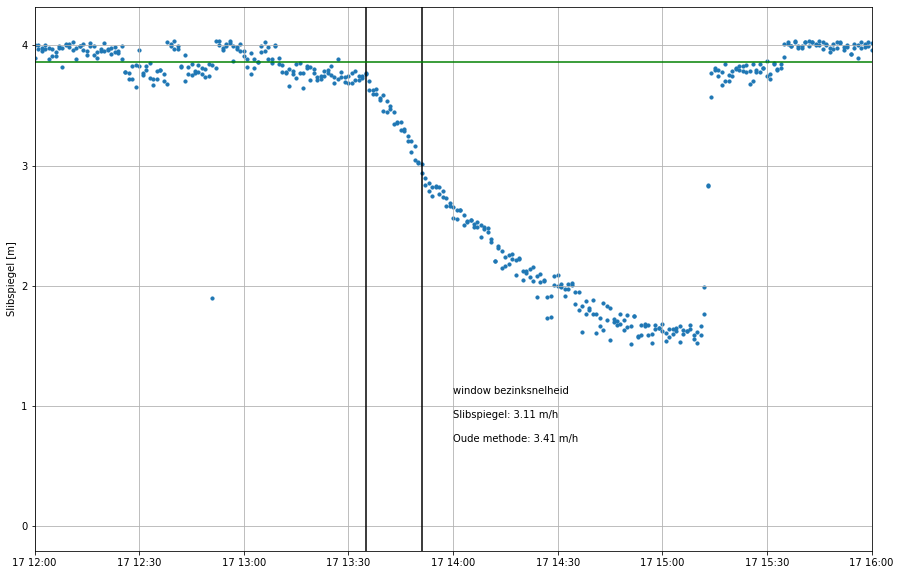

In [347]:
fig,ax =plt.subplots(figsize=(15,10))
plt.scatter(df_spiegel.index, df_spiegel["SH"], s=10)
ax.set_xlim(pd.to_datetime('2020-12-17 12:00:00'),pd.to_datetime('2020-12-17 16:00:00'))
plt.axvline("2020-12-17 13:35:00", color="black")
plt.axvline("2020-12-17 13:51:00", color="black")
plt.axhline(3.86, color="green")
ax.set_ylabel("Slibspiegel [m]")
plt.text("2020-12-17 14:00:00", 1.1, "window bezinksnelheid")
plt.text("2020-12-17 14:00:00", 0.9, 'Slibspiegel: %.2f m/h'%spiegelmetingen["2020-12-17 13:35:00"])
plt.text("2020-12-17 14:00:00", 0.7, 'Oude methode: %.2f m/h'%df1_filter.loc["2020-12-17 13:11:00","Totale snelheid1"])
plt.grid()
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Slibspiegelmeting\2020_12_17 13_35_00_sensor")
plt.show()

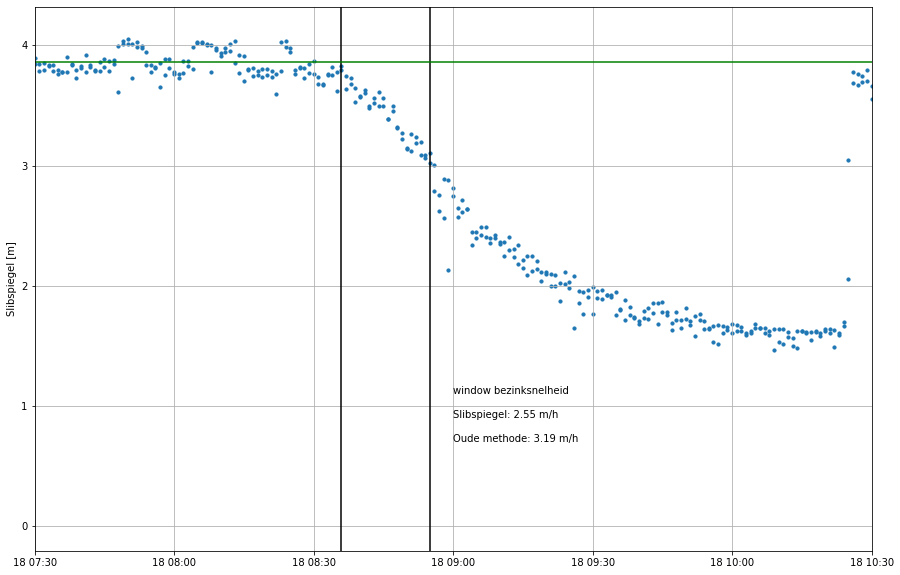

In [348]:
fig,ax =plt.subplots(figsize=(15,10))
plt.scatter(df_spiegel.index, df_spiegel["SH"], s=10)
ax.set_xlim(pd.to_datetime('2020-12-18 07:30:00'),pd.to_datetime('2020-12-18 10:30:00'))
plt.axvline("2020-12-18 08:36:00", color="black")
plt.axvline("2020-12-18 08:55:00", color="black")
plt.axhline(3.86, color="green")
ax.set_ylabel("Slibspiegel [m]")
plt.text("2020-12-18 09:00:00", 1.1, "window bezinksnelheid")
plt.text("2020-12-18 09:00:00", 0.9, 'Slibspiegel: %.2f m/h'%spiegelmetingen["2020-12-18 08:36:00"])
plt.text("2020-12-18 09:00:00", 0.7, 'Oude methode: %.2f m/h'%df1_filter.loc["2020-12-18 08:23:00","Totale snelheid1"])
plt.grid()
plt.savefig(r"P:\1263819\Biologische opstart Weesp\Berend\Plan van aanpak onderzoek\Slibspiegelmeting\2020_12_18 08_36_00_sensor")
plt.show()

In [297]:
spiegelmetingen = {}

# Meetpunt 1
snelheid = df1_filter.loc["2020-12-16 18:00:00"]["Totale snelheid1"]
duur = df1_filter.loc["2020-12-16 18:00:00"]["Duur1"]
print(duur*60)
max_s = df_spiegel.loc["2020-12-16 18:15:00":"2020-12-16 18:37:00","SH"].max()
min_s = df_spiegel.loc["2020-12-16 18:15:00":"2020-12-16 18:37:00","SH"].min()
tijd_min = "18:15:00"
tijd_max = "18:37:00"
spiegelmetingen["2020-12-16 18:15:00"] = (max_s-min_s)/(22/60)

# Meetpunt 2
max_s = df_spiegel.loc["2020-12-17 13:35:00":"2020-12-17 13:51:00","SH"].max()
min_s = df_spiegel.loc["2020-12-17 13:35:00":"2020-12-17 13:51:00","SH"].min()
tijd_min = "13:35:00"
tijd_max = "13:51:00"
spiegelmetingen["2020-12-17 13:35:00"] = (max_s-min_s)/(16/60)

# Meetpunt 3
max_s = df_spiegel.loc["2020-12-18 08:36:00":"2020-12-18 08:55:00","SH"].max()
min_s = df_spiegel.loc["2020-12-18 08:36:00":"2020-12-18 08:55:00","SH"].min()
print(min_s)
tijd_min = "08:36:00"
tijd_max = "08:55:00"
spiegelmetingen["2020-12-18 08:36:00"] = (max_s-min_s)/(19/60)

29.0
3.022533
